# Neural Ordinary Differential Equation (NODE) algorithm for modeling dynamics of motor

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,max_error
con = False
# Check if MPS is available
if torch.backends.mps.is_available() and con == True:
    device = torch.device("mps")
    print("GPU set")
else:
    device = torch.device("cpu")

Model architecture

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class NN(nn.Module):
    """
    A flexible fully connected neural network (multi-layer perceptron) with options for:
    - Custom hidden layer sizes
    - Choice of activation function (ReLU, Tanh, Sigmoid)
    - Optional Batch Normalization
    - Optional Dropout
    - Weight initialization (Xavier uniform)

    Parameters:
    -----------
    input_dim : int
        Dimension of the input features.

    output_dim : int
        Dimension of the output layer.

    hidden_sizes : list of int
        Sizes of the hidden layers (e.g., [64, 128, 64]).

    activation : str
        Activation function to use: 'relu', 'tanh', or 'sigmoid'.

    dropout_rate : float
        Dropout probability (0 means no dropout).

    batch_norm : bool
        Whether to apply Batch Normalization after each hidden layer.

    seed : int or None
        Random seed for weight initialization (for reproducibility).
    """
    def __init__(self, input_dim, output_dim, hidden_sizes, activation, dropout_rate, batch_norm, seed):
        super(NN, self).__init__()
        if seed is not None:
            torch.manual_seed(seed)

        self.activation = activation
        self.dropout_rate = dropout_rate
        self.batch_norm = batch_norm

        layers = []
        batch_norm_layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, hidden_sizes[0]))
        if batch_norm:
            batch_norm_layers.append(nn.BatchNorm1d(hidden_sizes[0]))

        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            if batch_norm:
                batch_norm_layers.append(nn.BatchNorm1d(hidden_sizes[i + 1]))

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_dim))

        self.layers = nn.ModuleList(layers)
        self.batch_norm_layers = nn.ModuleList(batch_norm_layers) if batch_norm else None
        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None

        # Activation function
        if activation == 'tanh':
            self.activation_fn = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation_fn = nn.Sigmoid()
        elif activation == 'relu':
            self.activation_fn = nn.ReLU()

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initializes the weights of the Linear layers using Xavier uniform distribution
        and sets biases to zero.
        """
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)  # Xavier initialization
                nn.init.zeros_(layer.bias)  # Zero bias initialization

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch_size, input_dim)

        Returns:
        --------
        torch.Tensor
            Output tensor of shape (batch_size, output_dim)
        """
        for i, layer in enumerate(self.layers[:-1]):  
            x = layer(x)
            if self.batch_norm:
                x = self.batch_norm_layers[i](x)  # Apply Batch Normalization
            x = self.activation_fn(x)
            if self.dropout:
                x = self.dropout(x)  # Apply Dropout

        # Output layer (no activation)
        x = self.layers[-1](x)
        return x

class DynamicModel(nn.Module):
    """
    A dynamic system model that evolves a hidden state using Runge-Kutta numerical integration,
    based on a learned predictor network.

    Supports:
    - Classic RK4 integration
    - RK4 with time-varying inputs
    - Adaptive step-size RK4 integration

    Parameters:
    -----------
    predictor : nn.Module
        A neural network that models the derivative function of the state.

    step_size : float
        Initial step size (h) for integration.
    """
    def __init__(self, predictor, step_size):
        super(DynamicModel, self).__init__()
        self.predictor = predictor  
        self.h = step_size

    def rk4(self, x, x_hat):
        """
        Performs classic RK4 integration using fixed input `x`.

        Parameters:
        -----------
        x : torch.Tensor
            External input (assumed constant over the RK4 step).
        
        x_hat : torch.Tensor
            Current state estimate.

        Returns:
        --------
        torch.Tensor
            Next state after one integration step.
        """
        h = self.h 
        # Compute RK4 stages
        k1 = self.predictor(torch.cat((x, x_hat), dim=-1))
        k2 = self.predictor(torch.cat((x, x_hat + 0.5 * h * k1), dim=-1))
        k3 = self.predictor(torch.cat((x, x_hat + 0.5 * h * k2), dim=-1))
        k4 = self.predictor(torch.cat((x, x_hat + h * k3), dim=-1))

        # RK4 integration formula to compute the next state
        next_state = x_hat + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        return next_state
    
    def rk4_withvar_inputs(self, x, x_hat):
        """
        RK4 integration where input `x` is assumed to vary over time.

        Parameters:
        -----------
        x : torch.Tensor
            Initial external input.

        x_hat : torch.Tensor
            Current state estimate.

        Returns:
        --------
        torch.Tensor
            Next state after one integration step, considering input variation.
        """
        h = self.h 
        # Compute RK4 stages
        k1 = self.predictor(torch.cat((x, x_hat), dim=-1))
        k2 = self.predictor(torch.cat((x + 0.5 * h , x_hat + 0.5 * h * k1), dim=-1))
        k3 = self.predictor(torch.cat((x + 0.5 * h, x_hat + 0.5 * h * k2), dim=-1))
        k4 = self.predictor(torch.cat((x + h, x_hat + h * k3), dim=-1))

        # RK4 integration formula to compute the next state
        next_state = x_hat + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        return next_state
    
    def adaptive_rk4(self, x, x_hat):
        """
        Performs adaptive RK4 integration using error estimation (RK5-style).

        Automatically adjusts the step size based on local error.

        Parameters:
        -----------
        x : torch.Tensor
            External input (assumed constant over the step).
        
        x_hat : torch.Tensor
            Current state estimate.

        Returns:
        --------
        torch.Tensor
            Next state after one integration step (RK4).
        """
        h = self.h
        tolerance=1e-4
        min_step=1e-6
        max_step=1.0

        # Compute RK4 stages
        k1 = self.predictor(torch.cat((x, x_hat), dim=-1))
        k2 = self.predictor(torch.cat((x, x_hat + 0.5 * h * k1), dim=-1))
        k3 = self.predictor(torch.cat((x, x_hat + 0.5 * h * k2), dim=-1))
        k4 = self.predictor(torch.cat((x, x_hat + h * k3), dim=-1))

        # RK4 solution
        next_state_rk4 = x_hat + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

        # Compute RK5 stages (extra stage for error estimation)
        k5 = self.predictor(torch.cat((x, x_hat + h * k4), dim=-1))
        
        # RK5 solution (higher order, more accurate)
        next_state_rk5 = x_hat + (h / 6.0) * (k1 + 4 * k3 + k5)

        # Estimate local error
        error = torch.norm(next_state_rk5 - next_state_rk4, p=2)  # L2 norm of difference

        # Adjust step size based on error
        if error > tolerance and h > min_step:
            self.h = max(min_step, h * 0.5)  # Reduce step size
        elif error < tolerance / 2 and h < max_step:
            self.h = min(max_step, h * 2)  # Increase step size

        return next_state_rk4
    
    def forward(self, inputs, state):
        """
        Forward pass for the dynamic model using fixed-step RK4 integration.

        Parameters:
        -----------
        inputs : torch.Tensor
            Input features for the current time step.

        state : torch.Tensor
            Current system state.

        Returns:
        --------
        torch.Tensor
            Next system state after integration.
        """
        x = self.rk4(inputs, state)

        return x

Data scaling to specific range

In [ ]:
def normalize_column(df, column_list, col_min, col_max, normalized_range):
    """
    Normalizes a column of a dataframe to the range [-1, 1].

    Parameters:
        df (pd.DataFrame): The input dataframe.
        column_name (str): The name of the column to normalize.
        
    Returns:
        pd.DataFrame: DataFrame with normalized column in the range [-1, 1].
    """
    for column_name in column_list:
        if normalized_range == (0, 1):
            # Normalize the column to the range [0, 1]
            df[column_name] = (df[column_name] - col_min) / (col_max - col_min)
        elif normalized_range == (-1, 1):
            # Normalize the column to the range [0, 1]
            df[column_name] = (df[column_name] - col_min) / (col_max - col_min)
        
            # Scale to the new range [-1, 1]
            df[column_name] = df[column_name] * 2 - 1
        else:
            raise ValueError("normalized_range must be either (0, 1) or (-1, 1)")
        
    return df

def denormalize(normalized_array, original_min, original_max, normalized_range):
    """
    Denormalizes a normalized array from the range [-1, 1] or [0, 1] back to the original range 
    [original_min, original_max].

    Parameters:
        normalized_array (list or np.ndarray): Multidimensional array of normalized values.
        original_min (float): The original minimum value before normalization.
        original_max (float): The original maximum value before normalization.
        normalized_range (tuple): Range used for normalization, either (0, 1) or (-1, 1).

    Returns:
        np.ndarray: A denormalized array in the original range [original_min, original_max].
    """
    # Convert to a numpy array (if not already) for easy element-wise operations
    normalized_array = np.array(normalized_array)
    
    if normalized_range == (-1, 1):
        # Denormalize from [-1, 1]
        denormalized_array = ((normalized_array + 1) / 2) * (original_max - original_min) + original_min
    elif normalized_range == (0, 1):
        # Denormalize from [0, 1]
        denormalized_array = normalized_array * (original_max - original_min) + original_min
    else:
        raise ValueError("normalized_range must be either (0, 1) or (-1, 1)")

    return denormalized_array

In [ ]:
def inference_dynamicmodel(dynamicmodel, X, Y):
    """
    Perform inference on the complete dataset using the RK4 integrator model.
    
    :param rk4_integrator: The RK4 integrator model for predictions.
    :param X: Tensor of shape [num_samples, sequence_length, nx] containing input data.
    :param ny: Number of output dimensions.
    :return: Tensor of shape [num_samples, sequence_length, ny] containing predicted states.
    """
    dynamicmodel.eval()  # Set the model to evaluation mode
    
    # Initialize the state variable xn to zero
    #xn = torch.zeros(ny, dtype=torch.float32)
    state = Y[0,:-1].unsqueeze(0).to(device)
    
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation
        for t in range(X.shape[0]):
            
            inputs = X[t, :].unsqueeze(0).to(device)
            
            # Predict the next state
            predicted_state = dynamicmodel(inputs, state)
            
            # Store the predicted state
            all_predictions.append(predicted_state)
            
            # Update state for the next time step
            state = predicted_state
        
    # Stack predictions to form the complete output tensor
    all_predictions = torch.stack(all_predictions, dim=1)  # Shape: [num_samples, sequence_length, ny]
    
    return all_predictions

def inference_sequential_training(dynamicdmodel, staticmodel, X, Y):
    """
    Perform inference on the complete dataset using the RK4 integrator model.
    
    :param rk4_integrator: The RK4 integrator model for predictions.
    :param X: Tensor of shape [num_samples, sequence_length, nx] containing input data.
    :param ny: Number of output dimensions.
    :return: Tensor of shape [num_samples, sequence_length, ny] containing predicted states.
    """
    dynamicdmodel.eval()  # Set the model to evaluation mode
    staticmodel.eval()
    
    # Initialize the state variable xn to zero
    state = Y[0,:-1].unsqueeze(0)
    
    current_predictions = []
    torque_predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for t in range(X.shape[0]):
            inputs = X[t, :].unsqueeze(0)
            speed_angle = X[t, 3:6].unsqueeze(0)
            
            predicted_current = dynamicdmodel(inputs, state)
            inputs = torch.cat([predicted_current ,speed_angle], dim=-1)
            
            predicted_torque = staticmodel(inputs)
            
            # Store the predicted state
            current_predictions.append(predicted_current)
            torque_predictions.append(predicted_torque)
            
            # Update state for the next time step
            state = predicted_current.detach()
        
    # Stack predictions to form the complete output tensor
    current_predictions = torch.stack(current_predictions, dim=1)  
    torque_predictions = torch.stack(torque_predictions, dim=1)
    
    return current_predictions, torque_predictions

def error_dynamicmodel(predictions , test_data):
    predictions = np.array(predictions)
    test_data = np.array(test_data)
    mae = np.mean(np.abs(predictions - test_data))
    mse = np.mean((predictions - test_data) ** 2)

    return mae,mse

def error_staticmodel(label,predictions):
    error = {}
    mean_err = mean_absolute_error(label,predictions)
    error["Mean absolute error"] = mean_err
    print(f"Mean absolute error: {mean_err}")
    
    mean_sq_err = mean_squared_error(label,predictions)
    error["Mean squared error"] = mean_sq_err
    print(f"Mean squared error: {mean_sq_err}")
    
    mean_ab_per_err = mean_absolute_percentage_error(label,predictions)
    error["Mean absolute percentage error"] = mean_ab_per_err
    print(f"Mean absolute percentage error: {mean_ab_per_err}")
        
    max_err = max_error(label,predictions)
    error["Maximum error"] = max_err
    print(f"Maximum error: {max_err}")

    return mean_err

def errormatrix(current_predictions, torque_predictions, Y_test_normalised, Y_test):
    mae, mse = error_dynamicmodel(current_predictions,  Y_test_normalised[:, :-1])
    print(f"Normalised data - Test error (MAE): {mae}, Test error (MSE): {mse}")

    current_predictions = torch.tensor(denormalize(current_predictions, -400, 400,(-1,1)))
    current_predictions = current_predictions.squeeze().T
    current_error_mae, mse = error_dynamicmodel(current_predictions,Y_test[:, :-1].T)
    print(f"Denormalised data - Test error (MAE): {current_error_mae}, Test error (MSE): {mse}\n")

    torque_predictions = torch.tensor(denormalize(torque_predictions, 0, 150,(0,1)),dtype=torch.float32)
    torque_predictions = torque_predictions.squeeze()
    torque_error_mae = error_staticmodel(Y_test[:, -1],torque_predictions)

    return current_predictions, torque_predictions, current_error_mae, torque_error_mae

In [ ]:
def data_train(df, input_cols, output_cols, nsim, prediction_horizon, batch_size):
    # Extract input and output data from DataFrame
    inputs = torch.tensor(df[input_cols].values, dtype=torch.float16)
    outputs = torch.tensor(df[output_cols].values, dtype=torch.float16)

    X = []
    Y = []

    # Calculate the number of sequences
    num_sequences = len(df) // nsim
    num_sim = torch.randperm(num_sequences)[:16]
    # print(num_sim)
    
    for i in num_sim:
        # Truncate data to fit exact number of sequences
        input_sim = inputs[i*nsim : (i+1)*nsim]
        output_sim = outputs[i*nsim : (i+1)*nsim]

        # Generate random indices for the batch
        indices = torch.randperm(nsim-prediction_horizon)[:batch_size]
        
        for j in indices:
            x = input_sim[j : j+prediction_horizon]
            y = output_sim[j : j+prediction_horizon]

            X.append(x)
            Y.append(y)

    X = torch.stack(X).to(torch.float32)
    Y = torch.stack(Y).to(torch.float32)
    
    return X, Y

def data_val(df, input_cols, output_cols, nsim, prediction_horizon, batch_size):
    # Extract input and output data from DataFrame
    inputs = torch.tensor(df[input_cols].values, dtype=torch.float16)
    outputs = torch.tensor(df[output_cols].values, dtype=torch.float16)

    X = []
    Y = []

    # Calculate the number of sequences
    num_sequences = len(df) // nsim
    num_sim = torch.randperm(num_sequences)[:6]

    for i in num_sim :
        # Truncate data to fit exact number of sequences
        input_sim = inputs[i*nsim : (i+1)*nsim]
        output_sim = outputs[i*nsim : (i+1)*nsim]

        X.append(input_sim)
        Y.append(output_sim)

    X = torch.stack(X).to(torch.float32)
    Y = torch.stack(Y).to(torch.float32)
    
    return X, Y

def prepare_dataset_staticmodel(dynamicmodel, X, Y, nsim, batch_size):

    sequence_length = X.shape[0]//nsim
    x_train = torch.empty(0, 6)  
    y_train = torch.empty(0, 1).squeeze()

    for i in range(sequence_length):
        x = X[i*nsim : (i+1)*nsim]
        y = Y[i*nsim : (i+1)*nsim]
        current_predictions = inference_dynamicmodel(dynamicmodel, x, y)
        current = current_predictions.squeeze()
        speed_angle = x[:, 3:6]
        
        input = torch.concat([current,speed_angle], dim=1)
        output = y[:,-1]
        
        x_train = torch.concat([x_train,input], dim=0)
        y_train = torch.concat([y_train,output], dim=0)

    dataset = TensorDataset(x_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

Training loops for dynamic and static model

In [ ]:
def train_dynamicmodel(dynamicmodel, df, input_cols, output_cols, batch_size, nsim, prediction_horizon, num_epochs, lr, early_stopping, patience):
    optimizer = optim.Adam(dynamicmodel.parameters(), lr=lr)
    loss_mse = nn.MSELoss()  
    train_mseloss_list = []
    val_mseloss_list = []

    # Hyperparameters for early stopping
    patience = patience  # Number of epochs to wait for improvement
    best_loss = float('inf')
    wait = 0  # Counter for epochs without improvement

    # Ensure data is float32
    dynamicmodel.to(torch.float32)
    try:
        for epoch in range(num_epochs):
            dynamicmodel.train()
            train_mseloss = 0
            
            batch_x, batch_y = data_train(df, input_cols, output_cols, nsim, prediction_horizon, batch_size)
            prediction_horizon_loss = torch.tensor(0.0, requires_grad=True)
            state = batch_y[:, 0, :-1].to(device)
            
            # Process each time step in the batch
            for t in range(prediction_horizon-1):
                # Get current time step input
                inputs = batch_x[:, t+1, :].to(device)
                current_y = batch_y[:, t+1, :-1].to(device)
                
                # Predict the next state with RK4 integrator
                current_prediction = dynamicmodel(inputs, state)
            
                # Compute loss (MSE between predicted and true current values)
                loss = loss_mse(current_prediction, current_y)
                prediction_horizon_loss = prediction_horizon_loss + loss
                
                # Update state for the next time step
                state = current_prediction.detach()
            
            # Backward pass and optimization
            optimizer.zero_grad()
            prediction_horizon_loss.backward()
            optimizer.step()
                
            train_mseloss = prediction_horizon_loss.item()/(prediction_horizon)
            train_mseloss_list.append(train_mseloss)
            

            dynamicmodel.eval()
            #batch_x, batch_y = random_batch(X_val, Y_val, batch_size, nsim-prediction_horizon)
            batch_x, batch_y = data_val(df, input_cols, output_cols, nsim, prediction_horizon, batch_size)
            total_loss = torch.tensor(0.0, requires_grad=True)
            state = batch_y[:, 0, :-1].to(device)

            for t in range(nsim-1):
                # Get current time step input
                inputs = batch_x[:, t+1, :].to(device)
                current_y = batch_y[:, t+1, :-1].to(device)
        
                # Predict the next state with RK4 integrator
                current_prediction = dynamicmodel(inputs, state)
            
                # Compute loss (MSE between predicted and true current values)
                loss = loss_mse(current_prediction, current_y)
                total_loss = total_loss + loss

                # Update state for the next time step
                state = current_prediction.detach()
            val_mseloss = total_loss.item()/(nsim)
            val_mseloss_list.append(val_mseloss)
            
            print(f"Epoch {epoch + 1}/{num_epochs}, Train loss(MSE): {train_mseloss :.6f}, Validation loss(MSE): {val_mseloss :.6f}")

            # if early_stopping == True:
            #     # Check for early stopping condition
            #     if val_mseloss < best_loss:
            #         best_loss = val_mseloss
            #         wait = 0  # Reset the counter if improvement
            #         best_weights = copy.deepcopy(dynamicmodel.state_dict())
            #     else:
            #         wait += 1
                    
            #     if wait >= patience:
            #         print("Early stopping triggered.")
            #         dynamicmodel.load_state_dict(best_weights)
            #         break

            if val_mseloss < best_loss:
                    best_loss = val_mseloss
                    wait = 0  # Reset the counter if improvement
                    best_weights = copy.deepcopy(dynamicmodel.state_dict())

        dynamicmodel.load_state_dict(best_weights)

    except KeyboardInterrupt:
        return train_mseloss_list, val_mseloss_list
        
    return train_mseloss_list, val_mseloss_list

def train_staticmodel(staticmodel, dataloader, epochs, lr):
    staticmodel_optimizer = optim.Adam(staticmodel.parameters(), lr=lr)
    loss_mse = nn.MSELoss()
    staticmodel_loss_list = []
    print(len(dataloader))
    try:
        for epoch in range(epochs):
            staticmodel.train()
            batch_loss = 0
            for x, y in dataloader:
                y = y.unsqueeze(-1)
                torque_predictions = staticmodel(x)
                loss = loss_mse(torque_predictions, y)

                staticmodel_optimizer.zero_grad()
                loss.backward()
                staticmodel_optimizer.step()

                batch_loss += loss.item()
            train_loss = batch_loss/len(dataloader)
            staticmodel_loss_list.append(train_loss)

            print(f"Epoch {epoch + 1}/{epochs}, Static model MSE loss: {train_loss :.6f}")
    except KeyboardInterrupt:
        return staticmodel_loss_list
    
    return staticmodel_loss_list

Plots for inference

In [ ]:
def plot_losses(train_mseloss_list, val_mseloss_list, staticmodel_loss_list):
    _, axs = plt.subplots(2,1,figsize=(6,10))
    axs[0].plot(train_mseloss_list, label = "Train loss")
    axs[0].plot(val_mseloss_list, label="Val loss")
    axs[0].set_title("Prediction horizon loss")
    axs[0].set_xlabel("Number of epochs")
    axs[0].set_ylabel("MSE loss")
    axs[0].legend()


    axs[1].plot(staticmodel_loss_list)
    axs[1].set_title("Static model loss")
    axs[1].set_xlabel("Number of epochs")
    axs[1].set_ylabel("MSE")

    plt.show()

def plot_predictions(X_test, Y_test, current_predictions, torque_predictions):
    # Y = np.array(Y_test[:,-1].unsqueeze(-1))
    # y_trq_min = np.min(Y, axis=0)
    # y_trq_max = np.max(Y, axis=0)
    # print(y_trq_min,y_trq_max )

    _, axs = plt.subplots(5,1, figsize=(12,10))
    axs[0].plot(X_test[:,0], label = 'V1')
    axs[0].plot(X_test[:,1], label = 'V2')
    axs[0].plot(X_test[:,2], label = 'V3')
    axs[0].set_title(f"Speed:{ X_test[0,3]}     i_d: {X_test[0,6]}     i_q: {X_test[0,7]} ")
    axs[0].legend()

    axs[1].plot(Y_test[:,0], label = 'i_a')
    axs[1].plot(current_predictions[:, 0], label = 'i_a pred')
    axs[1].legend()

    axs[2].plot(Y_test[:,1], label = 'i_b')
    axs[2].plot(current_predictions[:,1], label = 'i_b pred')
    axs[2].legend()

    axs[3].plot(Y_test[:,2], label = 'i_c')
    axs[3].plot(current_predictions[:,2], label = 'i_c pred')
    axs[3].legend()

    axs[4].plot(Y_test[:,-1], label = 'Actual torque')
    axs[4].plot(torque_predictions, label = 'Predicted torque')
    #axs[4].set_ylim(y_trq_min, y_trq_max)
    axs[4].autoscale()
    axs[4].legend()

    plt.tight_layout()
    plt.show()

def plot_heatmap_with_values(x_list, x_label, y_list, y_label, values_list, value_label, cmap='viridis'):
    """
    Plots a heatmap using seaborn from three lists: x-coordinates, y-coordinates, and values.
    Values are displayed in each box, and a grid structure is added.

    Parameters:
        x_list (list or array): List of x-coordinates.
        y_list (list or array): List of y-coordinates.
        values_list (list or array): List of values corresponding to each (x, y) pair.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        value_label (str): Label for the colorbar and title.
        cmap (str): Colormap for the heatmap. Default is 'viridis'.
    
    Returns:
        None: Displays the heatmap.
    """
    # Create a DataFrame from the input lists
    data = pd.DataFrame({'x': x_list, 'y': y_list, 'value': values_list})
    
    # Pivot the DataFrame to create a 2D grid
    heatmap_data = data.pivot(index='y', columns='x', values='value')
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data, 
        cmap=cmap, 
        annot=True,  # Display values in each box
        fmt=".1f",  # Format for the annotations
        linewidths=0.5,  # Add grid lines
        linecolor='black',  # Color of grid lines
        cbar_kws={'label': value_label}  # Add label to colorbar
    )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(value_label)
    plt.show()

def plot_binned_heatmap(x_list, x_label, y_list, y_label, values_list, value_label, bins_x=5, bins_y=5, cmap='viridis'):
    """
    Plots a heatmap using seaborn with binned x and y values. Bin ranges are shown on both axes.
    
    Parameters:
        x_list (list or array): List of x-coordinates.
        y_list (list or array): List of y-coordinates.
        values_list (list or array): List of values corresponding to each (x, y) pair.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        value_label (str): Label for the colorbar and title.
        bins_x (int): Number of bins for the x-axis.
        bins_y (int): Number of bins for the y-axis.
        cmap (str): Colormap for the heatmap. Default is 'viridis'.
    
    Returns:
        None: Displays the heatmap.
    """
    # Create bins for x and y values
    x_bins = np.linspace(min(x_list), max(x_list), bins_x + 1)
    y_bins = np.linspace(min(y_list), max(y_list), bins_y + 1)
    
    # Digitize x and y values into bins
    x_bin_indices = np.digitize(x_list, x_bins, right=True)
    y_bin_indices = np.digitize(y_list, y_bins, right=True)
    
    # Create bin labels (ranges)
    x_bin_labels = [f'[{x_bins[i]:.1f}, {x_bins[i+1]:.1f}]' for i in range(len(x_bins)-1)]
    y_bin_labels = [f'[{y_bins[i]:.1f}, {y_bins[i+1]:.1f}]' for i in range(len(y_bins)-1)]
    
    # Create a DataFrame
    data = pd.DataFrame({'x_bin': x_bin_indices, 'y_bin': y_bin_indices, 'value': values_list})
    
    # Aggregate data by mean (or sum, depending on preference)
    heatmap_data = data.groupby(['y_bin', 'x_bin'])['value'].mean().unstack()
    
    # Ensure heatmap_data includes all bins
    heatmap_data = heatmap_data.reindex(index=range(1, bins_y+1), columns=range(1, bins_x+1), fill_value=np.nan)
    
    # Set bin labels as index/columns
    heatmap_data.index = y_bin_labels[:len(heatmap_data)]
    heatmap_data.columns = x_bin_labels[:len(heatmap_data.columns)]
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data, 
        cmap=cmap, 
        annot=True,  # Display values in each box
        fmt=".1f",  # Format for the annotations
        linewidths=0.5,  # Add grid lines
        linecolor='black',  # Color of grid lines
        cbar_kws={'label': value_label}  # Add label to colorbar
    )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(value_label)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

Parameters setting for dynamic and static models

In [ ]:
# Parameters for Dynamic model
ts = 0.00025 
nsim = 40000
prediction_horizon = 5000
batch_size_dy = 4
num_epochs_dy = 10000 
lr_dy = 0.001
early_stoping = True
patience = 500

# Parameters for Static models
nx_st = 6  
ny_st = 3  
batch_size_st = 256 
num_epochs_st = 1000 
lr_st = 0.001


Read and scaling data 

In [ ]:
train_data = pd.read_hdf('/Users/chiragangadi/Uni Siegen/WHB_IAS/02_Data/DOE6/train_dataset.h5', key='table')

traindata_normalised = normalize_column(train_data,['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]'], -420, 420, (-1,1))
traindata_normalised = normalize_column(traindata_normalised,['Speed'], 7000, 9400, (0,1))
traindata_normalised = normalize_column(traindata_normalised,['i_a', 'i_b', 'i_c'], -400, 400, (-1,1))
traindata_normalised = normalize_column(traindata_normalised,['Moving1.Torque [NewtonMeter]'], 0, 150, (0,1))

X_train = torch.tensor(traindata_normalised[['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed','sin(Phi_el [])','cos(Phi_el [])']].values, dtype=torch.float16)
Y_train = torch.tensor(traindata_normalised[['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]']].values, dtype=torch.float16)

#########################################################################################################################################

test_data = pd.read_hdf('/Users/chiragangadi/Uni Siegen/WHB_IAS/02_Data/DOE6/train_dataset.h5', key='table')

X_test = torch.tensor(test_data[['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed','sin(Phi_el [])','cos(Phi_el [])']].values, dtype=torch.float16)
X_test_p = torch.tensor(test_data[['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed','sin(Phi_el [])','cos(Phi_el [])','i_d_average','i_q_average', 'Average Torque']].values, dtype=torch.float16)
Y_test = torch.tensor(test_data[['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]']].values, dtype=torch.float16)
testdata_normalised = normalize_column(test_data,['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]'], -420, 420, (-1,1))
testdata_normalised = normalize_column(testdata_normalised,['Speed'], 7000, 9400, (0,1))
testdata_normalised = normalize_column(testdata_normalised,['i_a', 'i_b', 'i_c'], -400, 400, (-1,1))
testdata_normalised = normalize_column(testdata_normalised,['Moving1.Torque [NewtonMeter]'], 0, 150, (0,1))

X_test_normalised = torch.tensor(testdata_normalised[['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed','sin(Phi_el [])','cos(Phi_el [])']].values, dtype=torch.float16)
Y_test_normalised = torch.tensor(testdata_normalised[['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]']].values, dtype=torch.float16)

###############################################################################

df = traindata_normalised
input_cols = ['VM9.V [V]', 'VM7.V [V]', 'VM8.V [V]', 'Speed', 'sin(Phi_el [])','cos(Phi_el [])']
output_cols = ['i_a', 'i_b', 'i_c','Moving1.Torque [NewtonMeter]']

Initialize the neural network and the dynamic Neural ODE model, then train the system end-to-end

In [ ]:
# Instantiate the neural network predictor
neuralnet = NN(input_dim=9, output_dim=3, hidden_sizes=[128, 128], activation='tanh', dropout_rate=0, batch_norm=True, seed=12).to(device)

# Instantiate the RK4 integrator with the neural network
dynamicmodel = DynamicModel(neuralnet, ts)

#train_mseloss_list, val_mseloss_list = train_dynamicmodel(dynamicmodel, trainloader, X_val, Y_val, nsim, prediction_horizon, num_epochs_dy, lr_dy, early_stoping, patience)
train_mseloss_list, val_mseloss_list = train_dynamicmodel(dynamicmodel, df, input_cols, output_cols, batch_size_dy, nsim, prediction_horizon, num_epochs_dy, lr_dy, early_stoping, patience)

Epoch 1/10000, Train loss(MSE): 0.667972, Validation loss(MSE): 0.541030
Epoch 2/10000, Train loss(MSE): 0.440026, Validation loss(MSE): 0.351331
Epoch 3/10000, Train loss(MSE): 0.266257, Validation loss(MSE): 0.347842
Epoch 4/10000, Train loss(MSE): 0.199054, Validation loss(MSE): 0.174649
Epoch 5/10000, Train loss(MSE): 0.144319, Validation loss(MSE): 0.112104
Epoch 6/10000, Train loss(MSE): 0.151252, Validation loss(MSE): 0.163003
Epoch 7/10000, Train loss(MSE): 0.119881, Validation loss(MSE): 0.115579
Epoch 8/10000, Train loss(MSE): 0.121139, Validation loss(MSE): 0.191983
Epoch 9/10000, Train loss(MSE): 0.129386, Validation loss(MSE): 0.131347
Epoch 10/10000, Train loss(MSE): 0.117853, Validation loss(MSE): 0.094131
Epoch 11/10000, Train loss(MSE): 0.092266, Validation loss(MSE): 0.107723
Epoch 12/10000, Train loss(MSE): 0.106677, Validation loss(MSE): 0.116982
Epoch 13/10000, Train loss(MSE): 0.091489, Validation loss(MSE): 0.095119
Epoch 14/10000, Train loss(MSE): 0.074320, Vali

Predict current using the dynamic NODE model and prepare data for sequential training of the static model

In [ ]:
dynamicmodel = dynamicmodel.to(dtype=torch.float16)
dataloader_staticmodel = prepare_dataset_staticmodel(dynamicmodel, X_train, Y_train, nsim, batch_size_st)

staticmodel = NN(input_dim=6, output_dim=1, hidden_sizes=[32,32], activation='sigmoid', dropout_rate=0.2, batch_norm=True, seed=32)
staticmodel_loss_list = train_staticmodel(staticmodel, dataloader_staticmodel, num_epochs_st, lr_st)

3750
Epoch 1/1000, Static model MSE loss: 0.085778
Epoch 2/1000, Static model MSE loss: 0.020258
Epoch 3/1000, Static model MSE loss: 0.013635
Epoch 4/1000, Static model MSE loss: 0.012050
Epoch 5/1000, Static model MSE loss: 0.011305
Epoch 6/1000, Static model MSE loss: 0.010931
Epoch 7/1000, Static model MSE loss: 0.010686
Epoch 8/1000, Static model MSE loss: 0.010509
Epoch 9/1000, Static model MSE loss: 0.010376
Epoch 10/1000, Static model MSE loss: 0.010254
Epoch 11/1000, Static model MSE loss: 0.010184
Epoch 12/1000, Static model MSE loss: 0.010119
Epoch 13/1000, Static model MSE loss: 0.010045
Epoch 14/1000, Static model MSE loss: 0.009989
Epoch 15/1000, Static model MSE loss: 0.009961
Epoch 16/1000, Static model MSE loss: 0.009912
Epoch 17/1000, Static model MSE loss: 0.009859
Epoch 18/1000, Static model MSE loss: 0.009844
Epoch 19/1000, Static model MSE loss: 0.009796
Epoch 20/1000, Static model MSE loss: 0.009789
Epoch 21/1000, Static model MSE loss: 0.009757
Epoch 22/1000, St

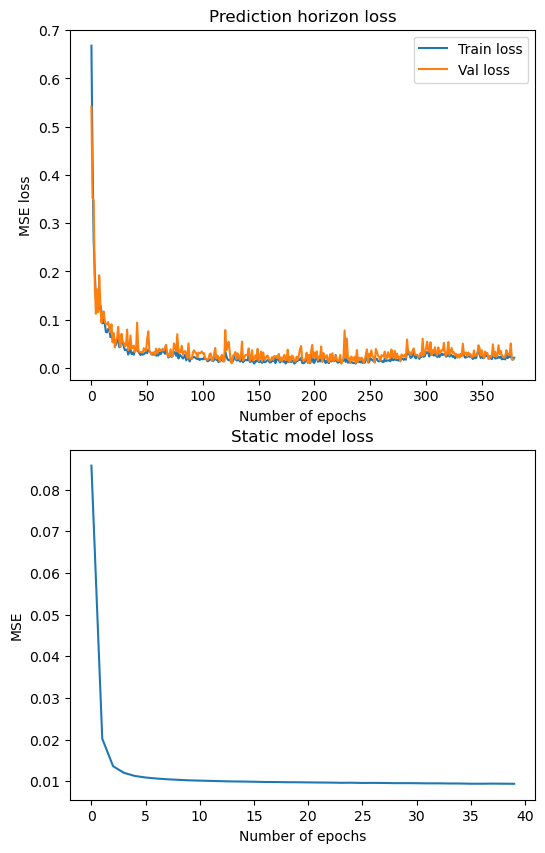

In [ ]:
plot_losses(train_mseloss_list, val_mseloss_list, staticmodel_loss_list)

Inference of dynamic and static model

Normalised data - Test error (MAE): 0.1317138671875, Test error (MSE): 0.0273284912109375
Denormalised data - Test error (MAE): 52.70293426513672, Test error (MSE): 4371.69970703125

Mean absolute error: 18.541555404663086
Mean squared error: 441.37078857421875
Mean absolute percentage error: 0.13973449170589447
Maximum error: 59.625


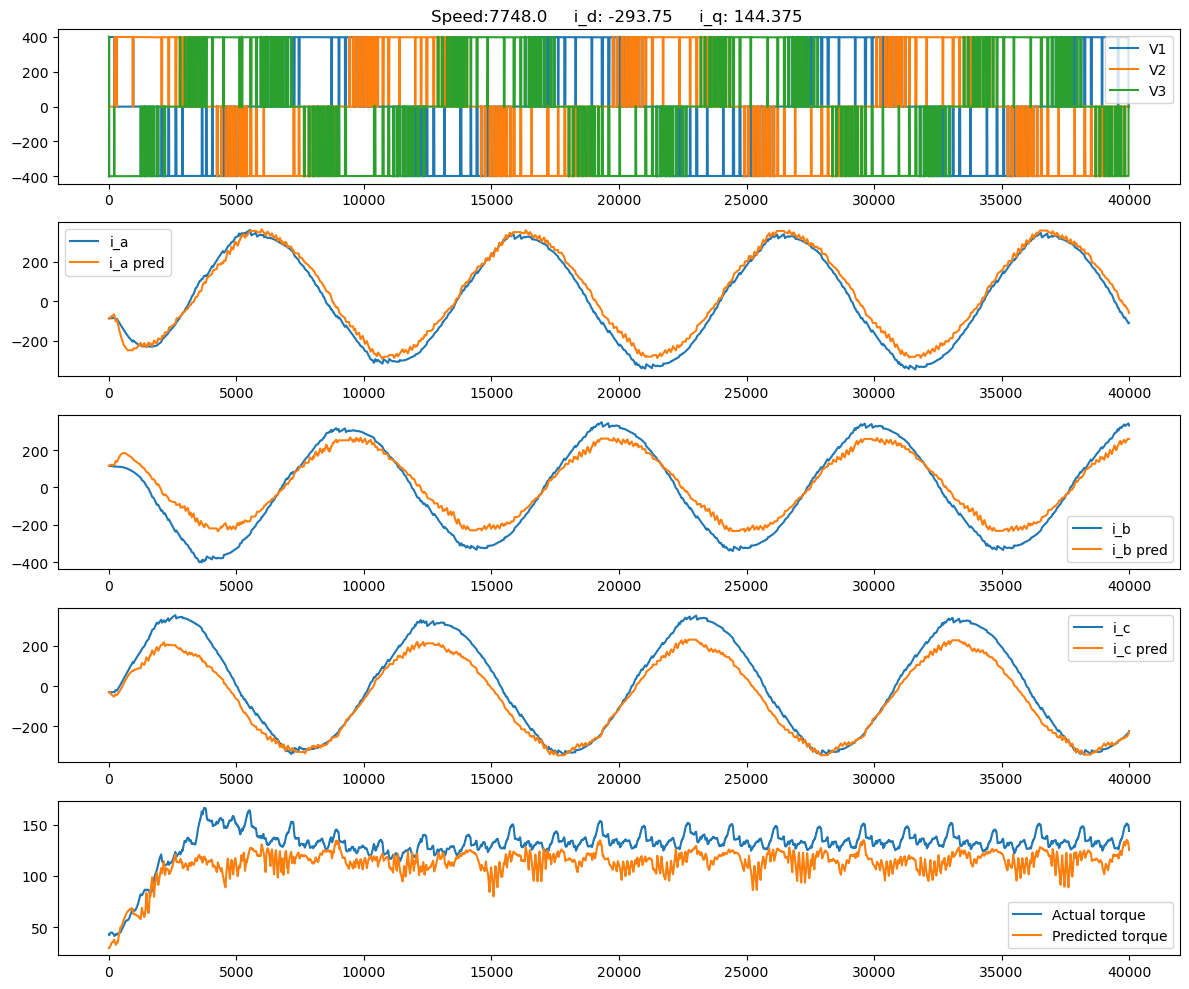

Normalised data - Test error (MAE): 0.11566162109375, Test error (MSE): 0.0197601318359375
Denormalised data - Test error (MAE): 46.271820068359375, Test error (MSE): 3161.78662109375

Mean absolute error: 9.0311861038208
Mean squared error: 154.69728088378906
Mean absolute percentage error: 0.18691924214363098
Maximum error: 56.625


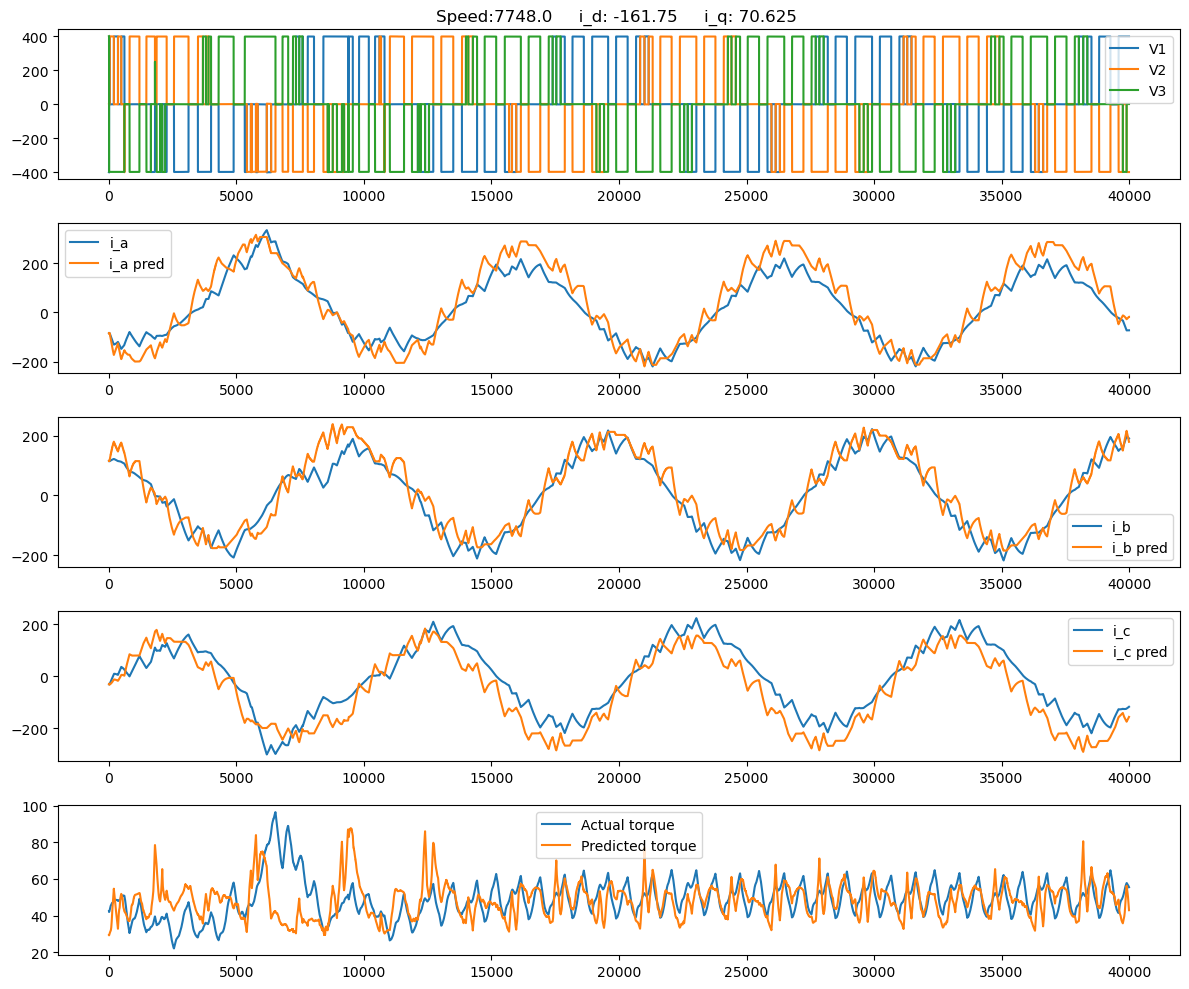

Normalised data - Test error (MAE): 0.11077880859375, Test error (MSE): 0.01898193359375
Denormalised data - Test error (MAE): 44.314178466796875, Test error (MSE): 3038.362548828125

Mean absolute error: 12.76053237915039
Mean squared error: 217.0665283203125
Mean absolute percentage error: 0.1871979534626007
Maximum error: 39.125


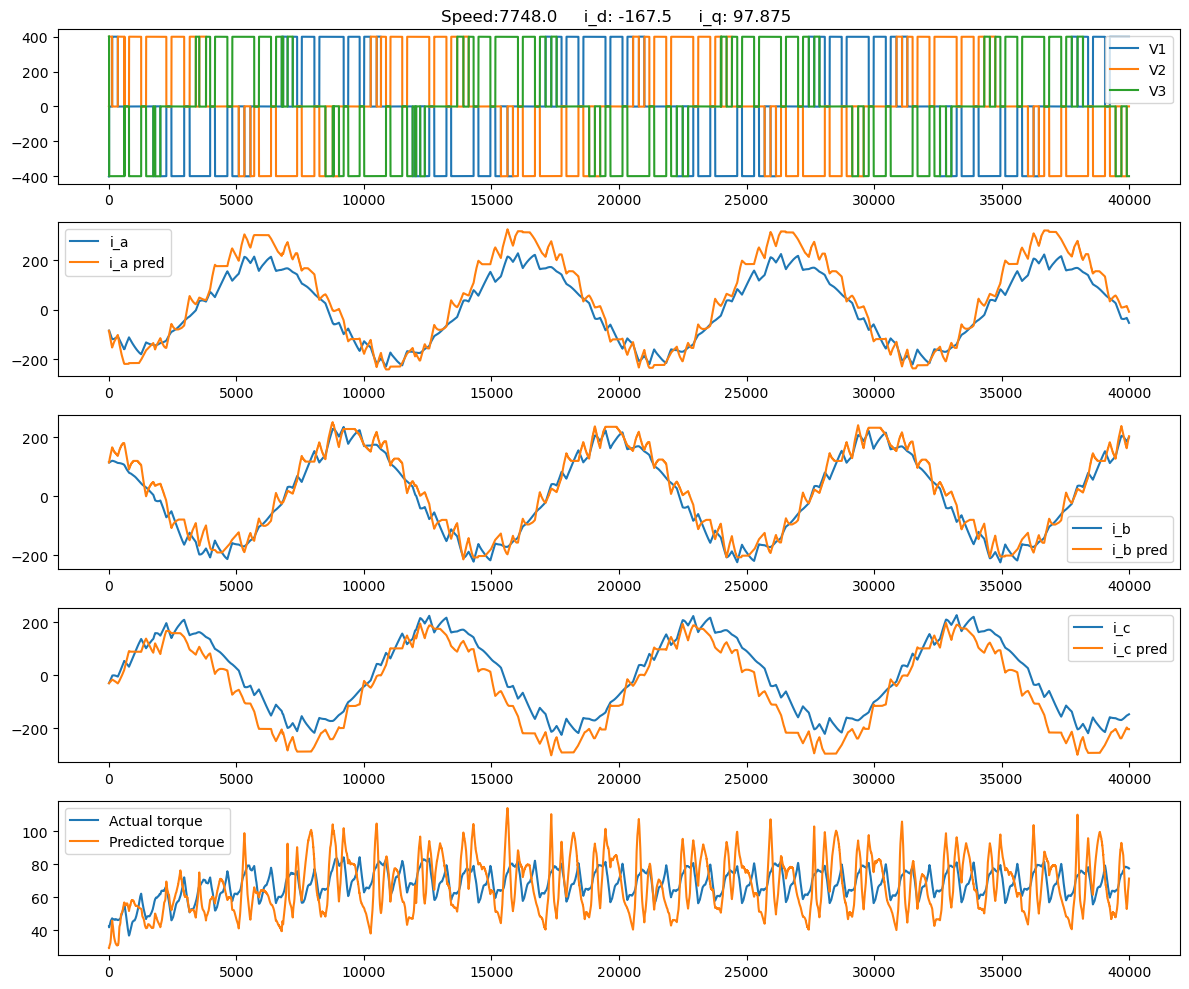

Normalised data - Test error (MAE): 0.1595458984375, Test error (MSE): 0.040283203125
Denormalised data - Test error (MAE): 63.802650451660156, Test error (MSE): 6446.5419921875

Mean absolute error: 8.728496551513672
Mean squared error: 128.30255126953125
Mean absolute percentage error: 0.20858626067638397
Maximum error: 40.65625


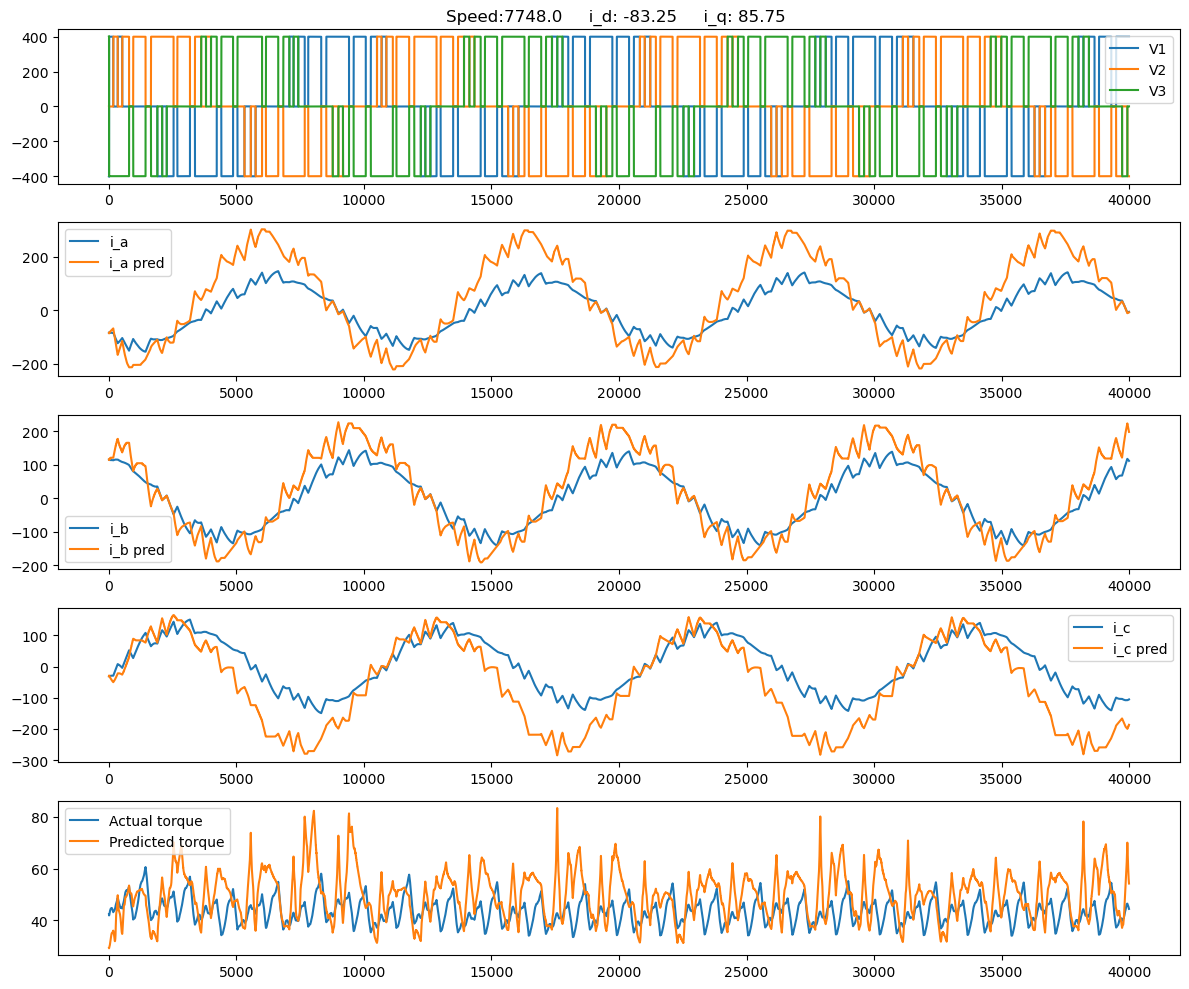

Normalised data - Test error (MAE): 0.1474609375, Test error (MSE): 0.03277587890625
Denormalised data - Test error (MAE): 58.97847366333008, Test error (MSE): 5244.4462890625

Mean absolute error: 11.36185359954834
Mean squared error: 163.29415893554688
Mean absolute percentage error: 0.9982571005821228
Maximum error: 29.41015625


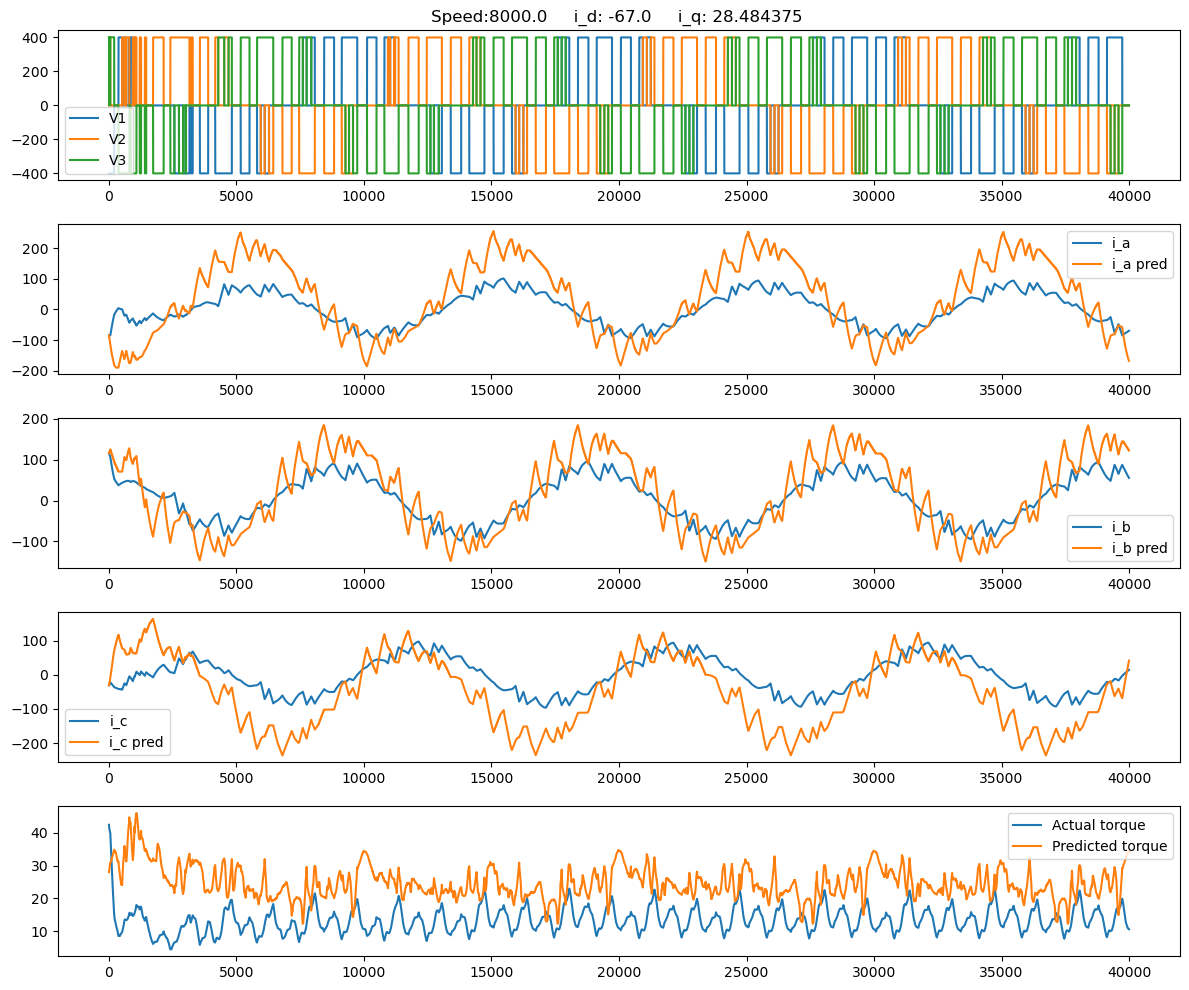

Normalised data - Test error (MAE): 0.143798828125, Test error (MSE): 0.0312042236328125
Denormalised data - Test error (MAE): 57.53573226928711, Test error (MSE): 4993.09814453125

Mean absolute error: 8.694636344909668
Mean squared error: 110.22137451171875
Mean absolute percentage error: 0.3047436773777008
Maximum error: 44.0625


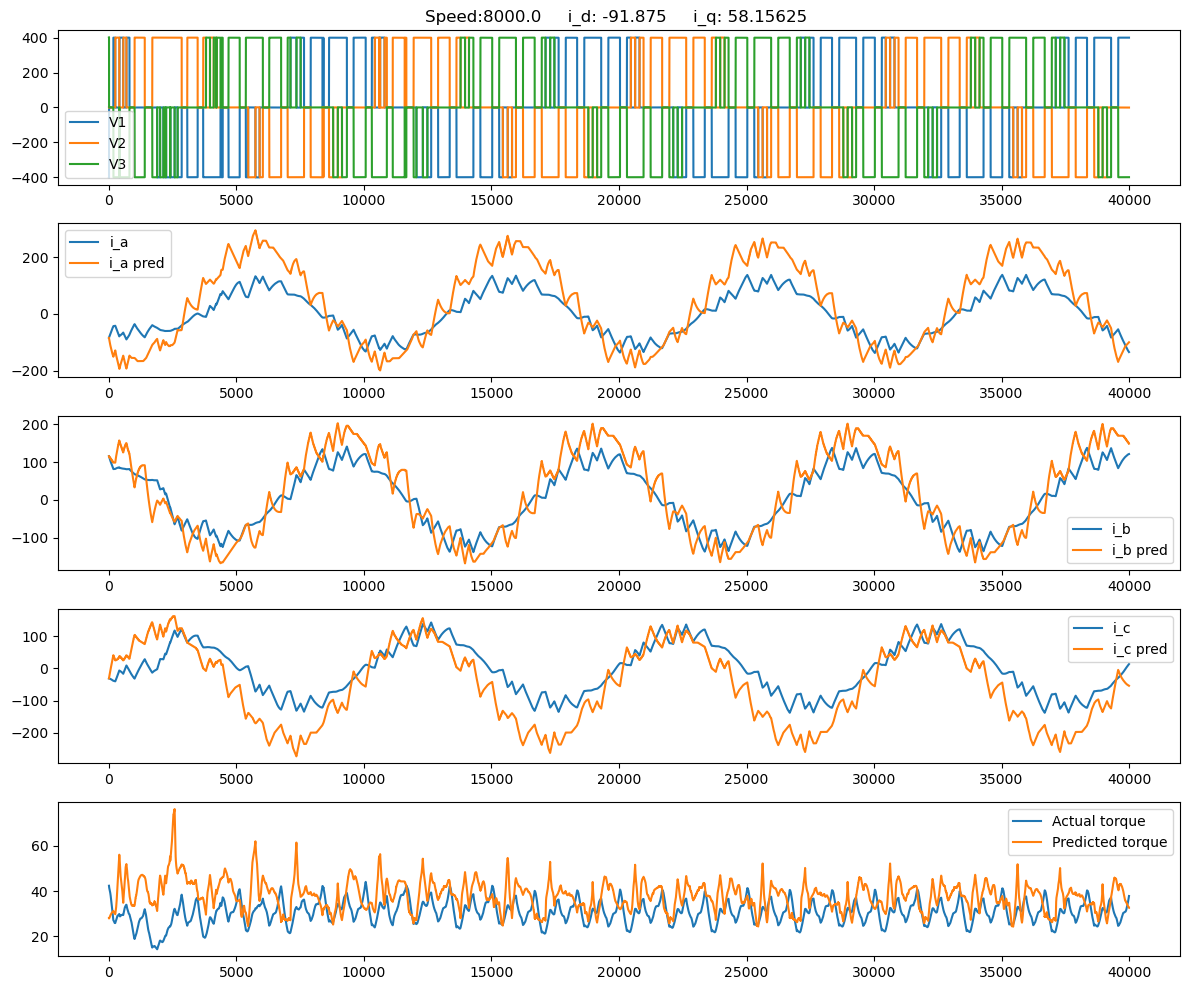

Normalised data - Test error (MAE): 0.11712646484375, Test error (MSE): 0.02069091796875
Denormalised data - Test error (MAE): 46.857425689697266, Test error (MSE): 3309.506591796875

Mean absolute error: 7.547079086303711
Mean squared error: 96.52069091796875
Mean absolute percentage error: 0.23371723294258118
Maximum error: 50.21875


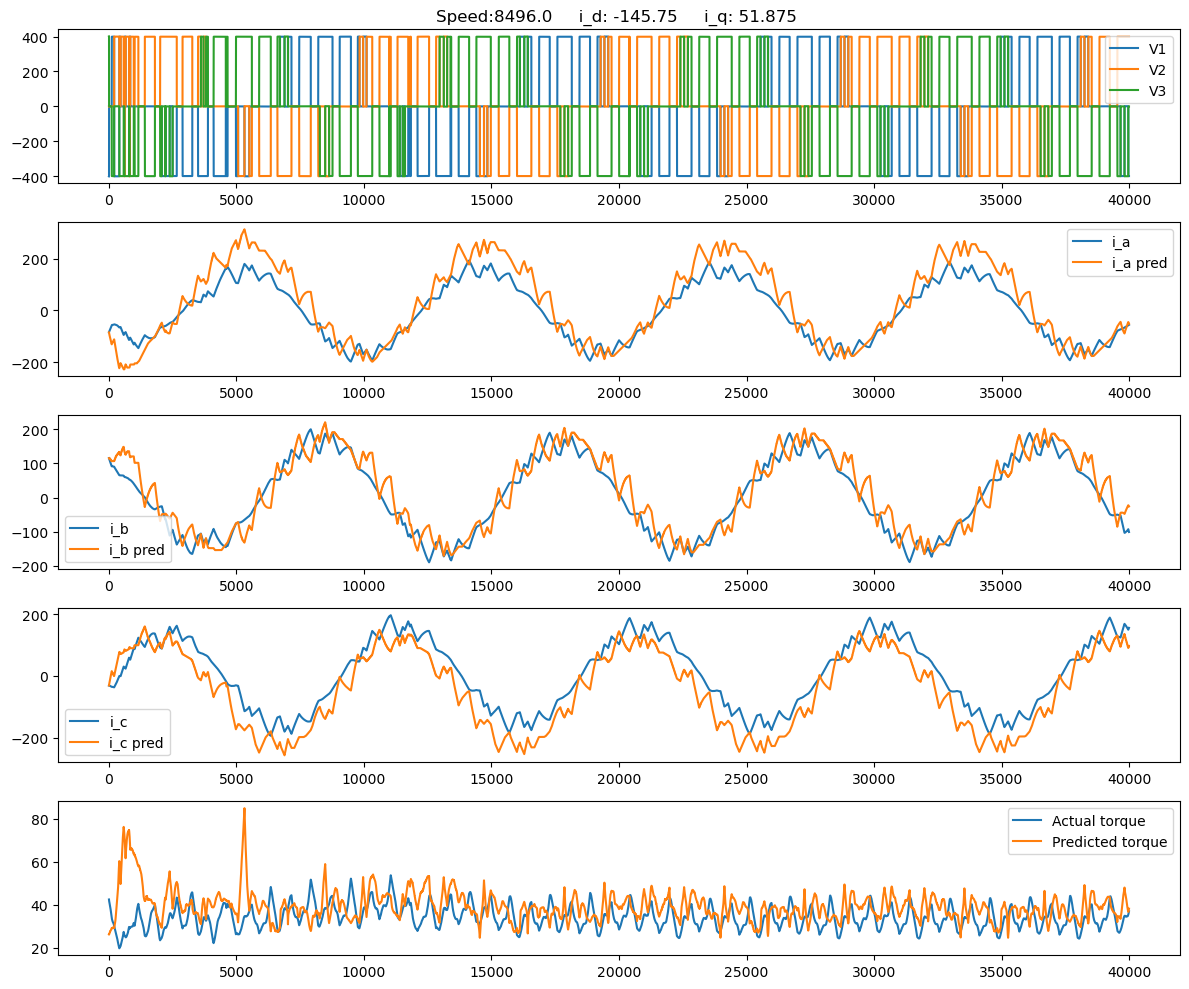

Normalised data - Test error (MAE): 0.11871337890625, Test error (MSE): 0.0214080810546875
Denormalised data - Test error (MAE): 47.48595428466797, Test error (MSE): 3424.74169921875

Mean absolute error: 7.661345481872559
Mean squared error: 94.94149017333984
Mean absolute percentage error: 0.25140199065208435
Maximum error: 44.90625


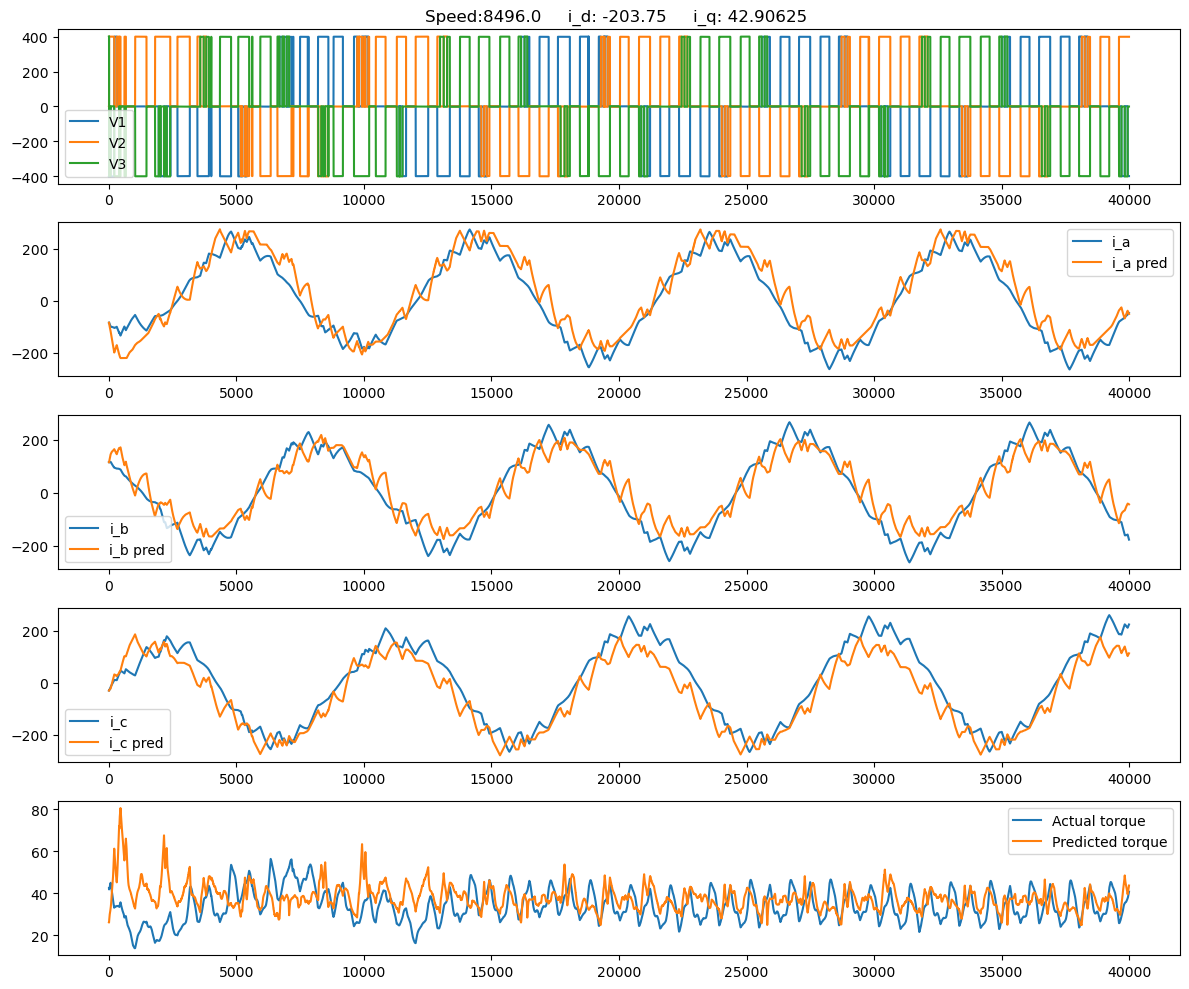

Normalised data - Test error (MAE): 0.12213134765625, Test error (MSE): 0.02130126953125
Denormalised data - Test error (MAE): 48.84507369995117, Test error (MSE): 3407.571044921875

Mean absolute error: 12.161364555358887
Mean squared error: 273.48101806640625
Mean absolute percentage error: 0.1114468052983284
Maximum error: 75.875


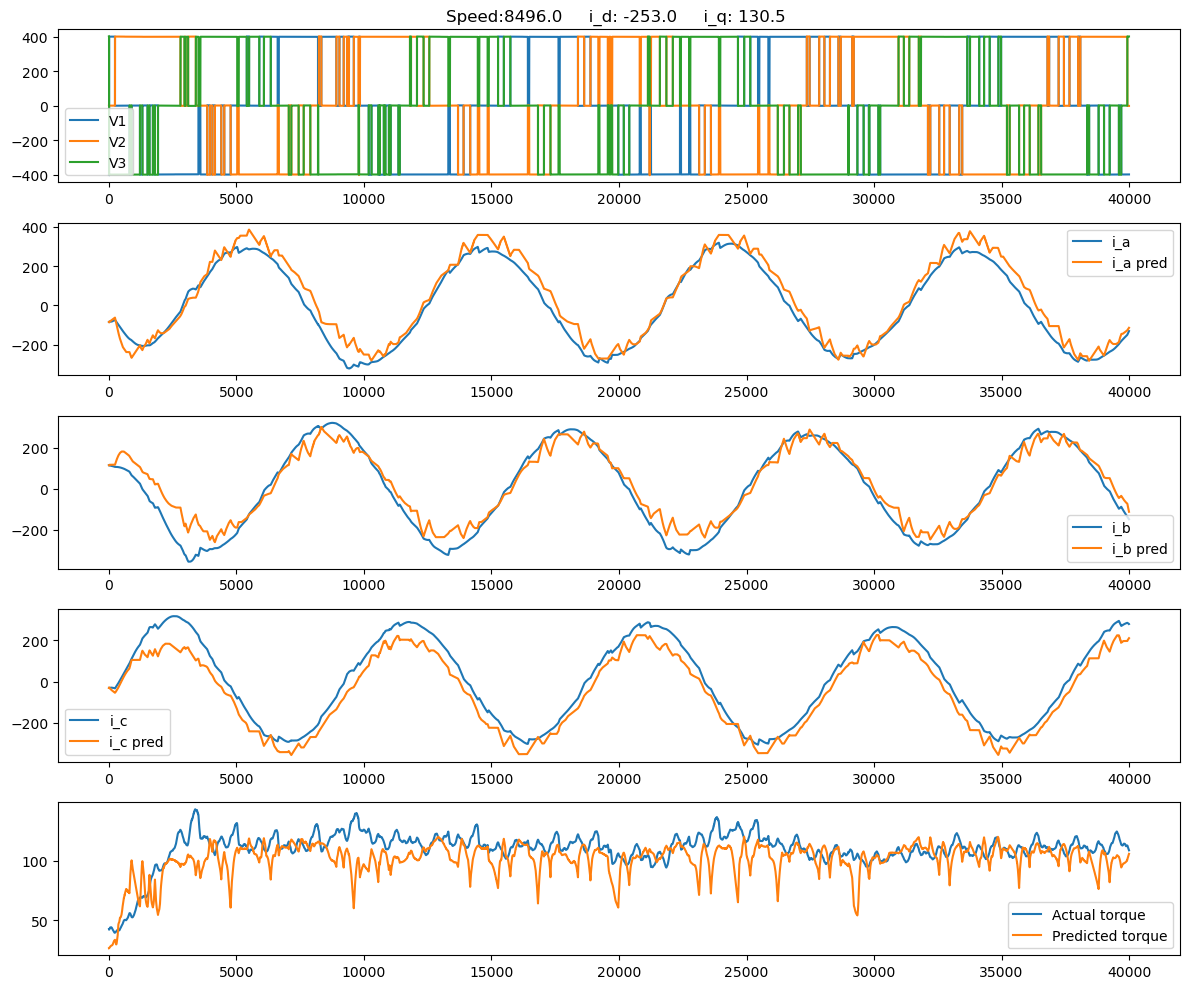

Normalised data - Test error (MAE): 0.1529541015625, Test error (MSE): 0.034423828125
Denormalised data - Test error (MAE): 61.18387222290039, Test error (MSE): 5509.8046875

Mean absolute error: 14.370584487915039
Mean squared error: 339.7853088378906
Mean absolute percentage error: 0.16097795963287354
Maximum error: 66.375


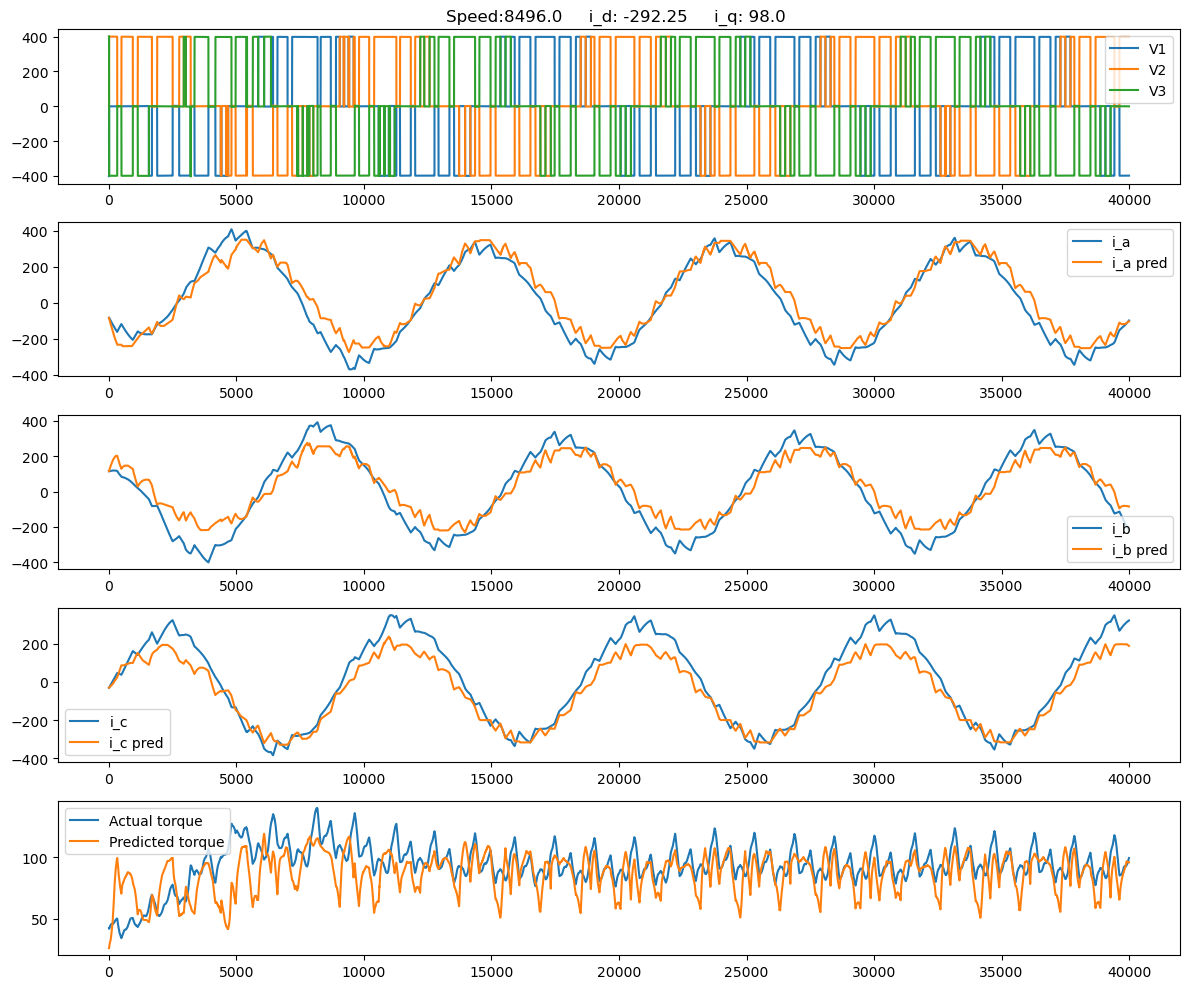

Normalised data - Test error (MAE): 0.120361328125, Test error (MSE): 0.02130126953125
Denormalised data - Test error (MAE): 48.15264892578125, Test error (MSE): 3407.24755859375

Mean absolute error: 6.696606159210205
Mean squared error: 65.55311584472656
Mean absolute percentage error: 0.32934239506721497
Maximum error: 26.6640625


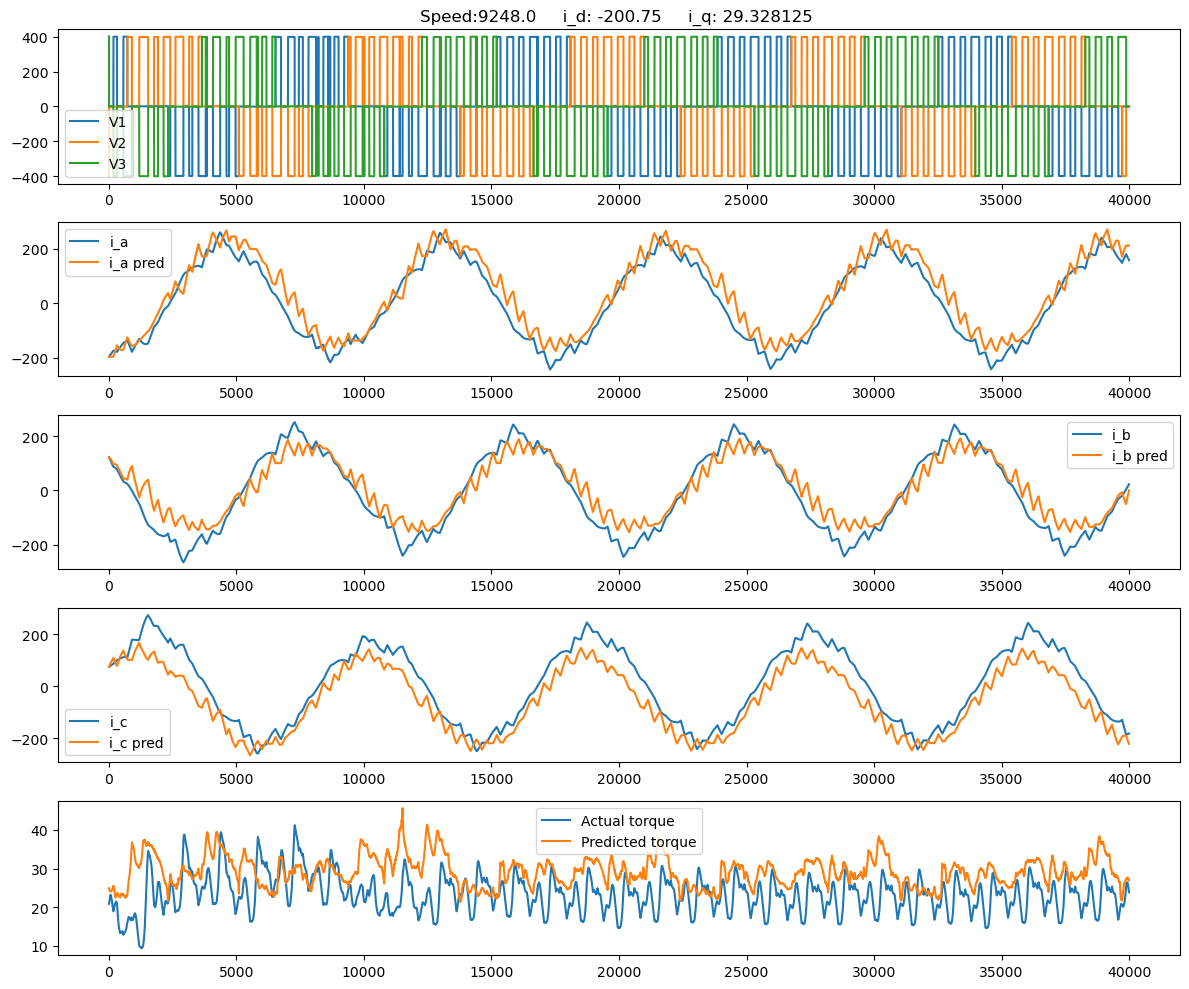

Normalised data - Test error (MAE): 0.1329345703125, Test error (MSE): 0.0260772705078125
Denormalised data - Test error (MAE): 53.17738723754883, Test error (MSE): 4171.59765625

Mean absolute error: 9.228652000427246
Mean squared error: 135.63339233398438
Mean absolute percentage error: 0.14501047134399414
Maximum error: 56.3125


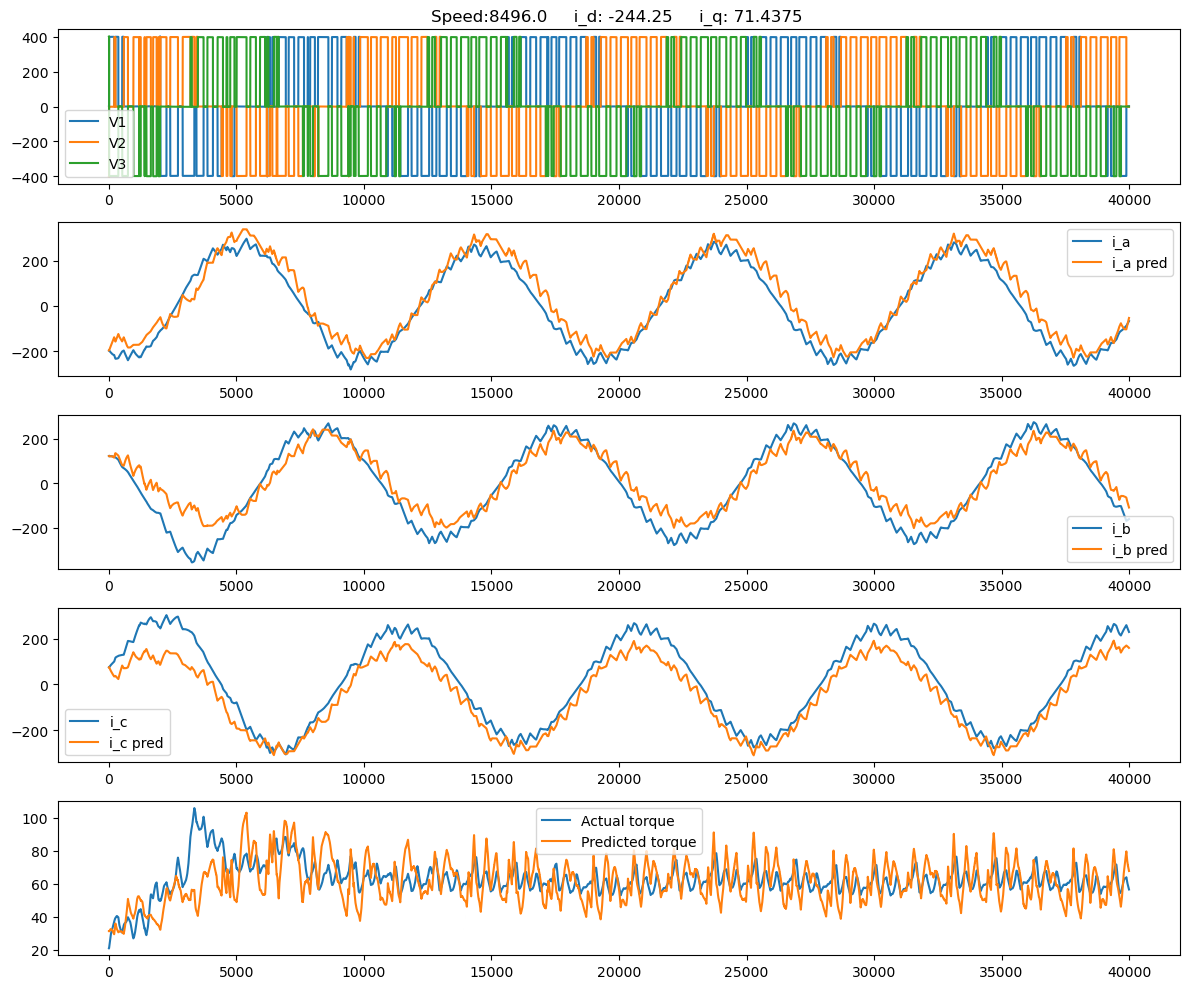

Normalised data - Test error (MAE): 0.11944580078125, Test error (MSE): 0.0205230712890625
Denormalised data - Test error (MAE): 47.78732681274414, Test error (MSE): 3283.590576171875

Mean absolute error: 9.197355270385742
Mean squared error: 154.8926544189453
Mean absolute percentage error: 0.09933537244796753
Maximum error: 58.6875


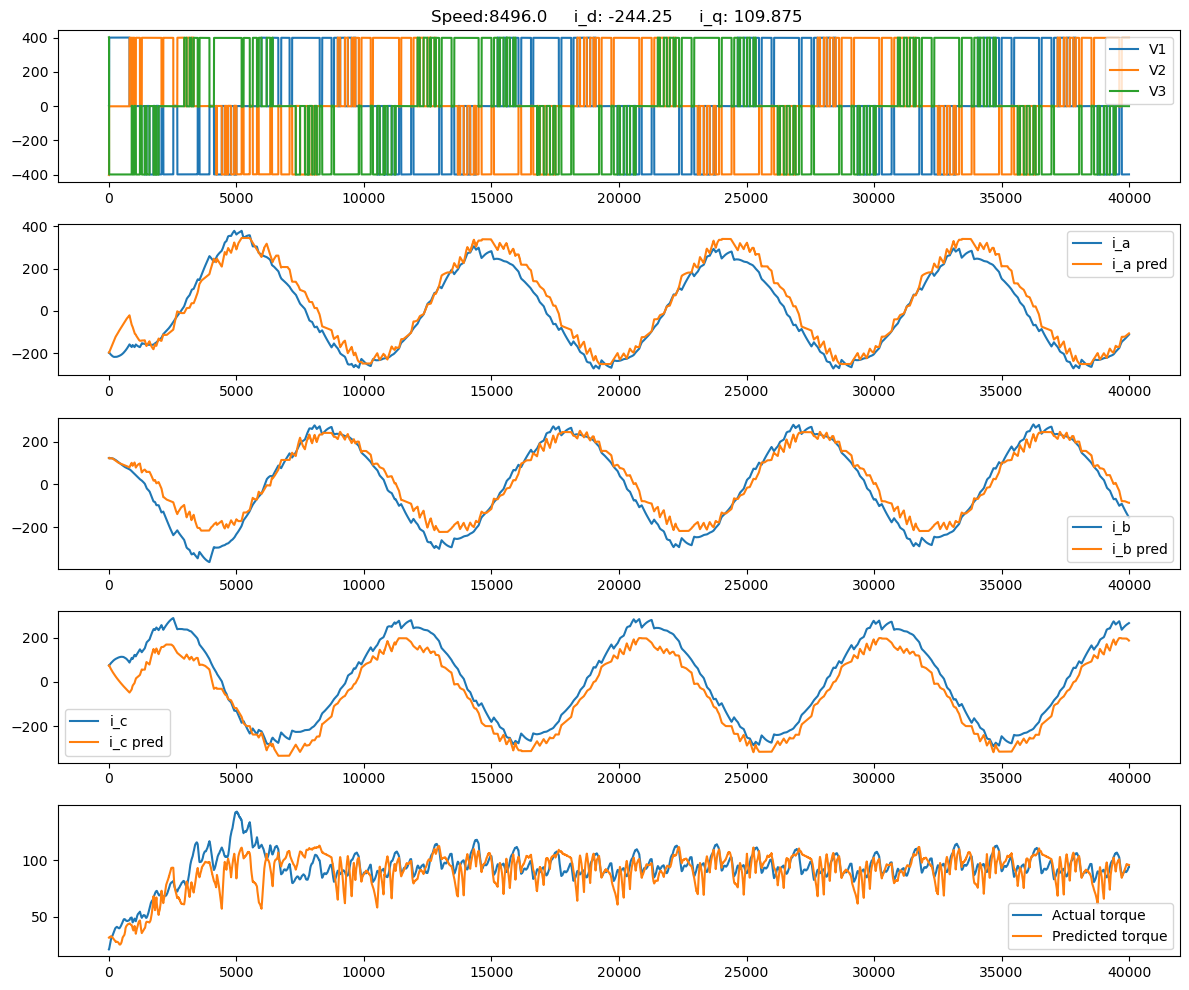

Normalised data - Test error (MAE): 0.17431640625, Test error (MSE): 0.044189453125
Denormalised data - Test error (MAE): 69.72492218017578, Test error (MSE): 7068.11572265625

Mean absolute error: 8.212127685546875
Mean squared error: 117.49462127685547
Mean absolute percentage error: 0.1691158413887024
Maximum error: 35.65625


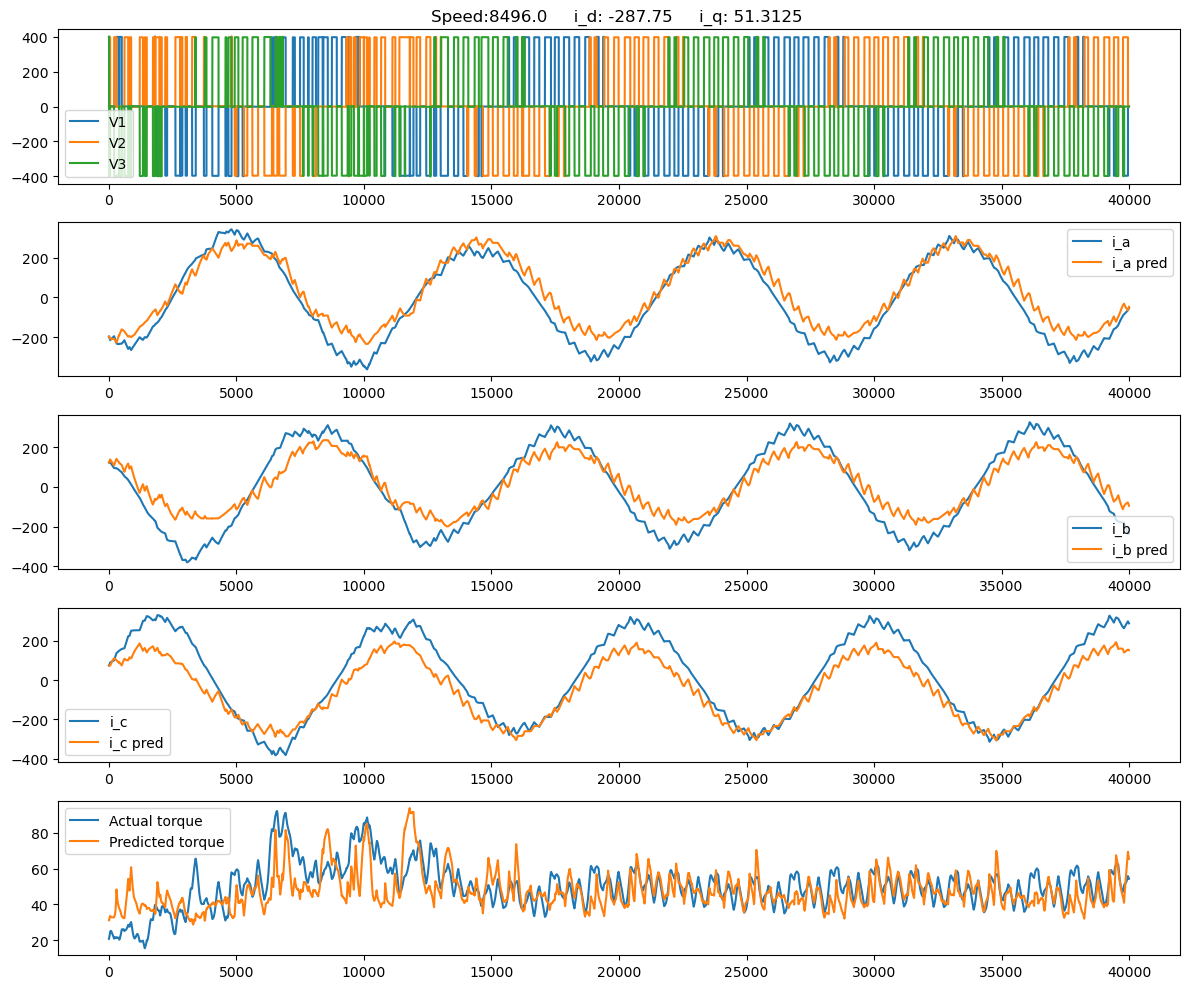

Normalised data - Test error (MAE): 0.148193359375, Test error (MSE): 0.033477783203125
Denormalised data - Test error (MAE): 59.261653900146484, Test error (MSE): 5358.30517578125

Mean absolute error: 9.530522346496582
Mean squared error: 158.72438049316406
Mean absolute percentage error: 0.20708926022052765
Maximum error: 43.5


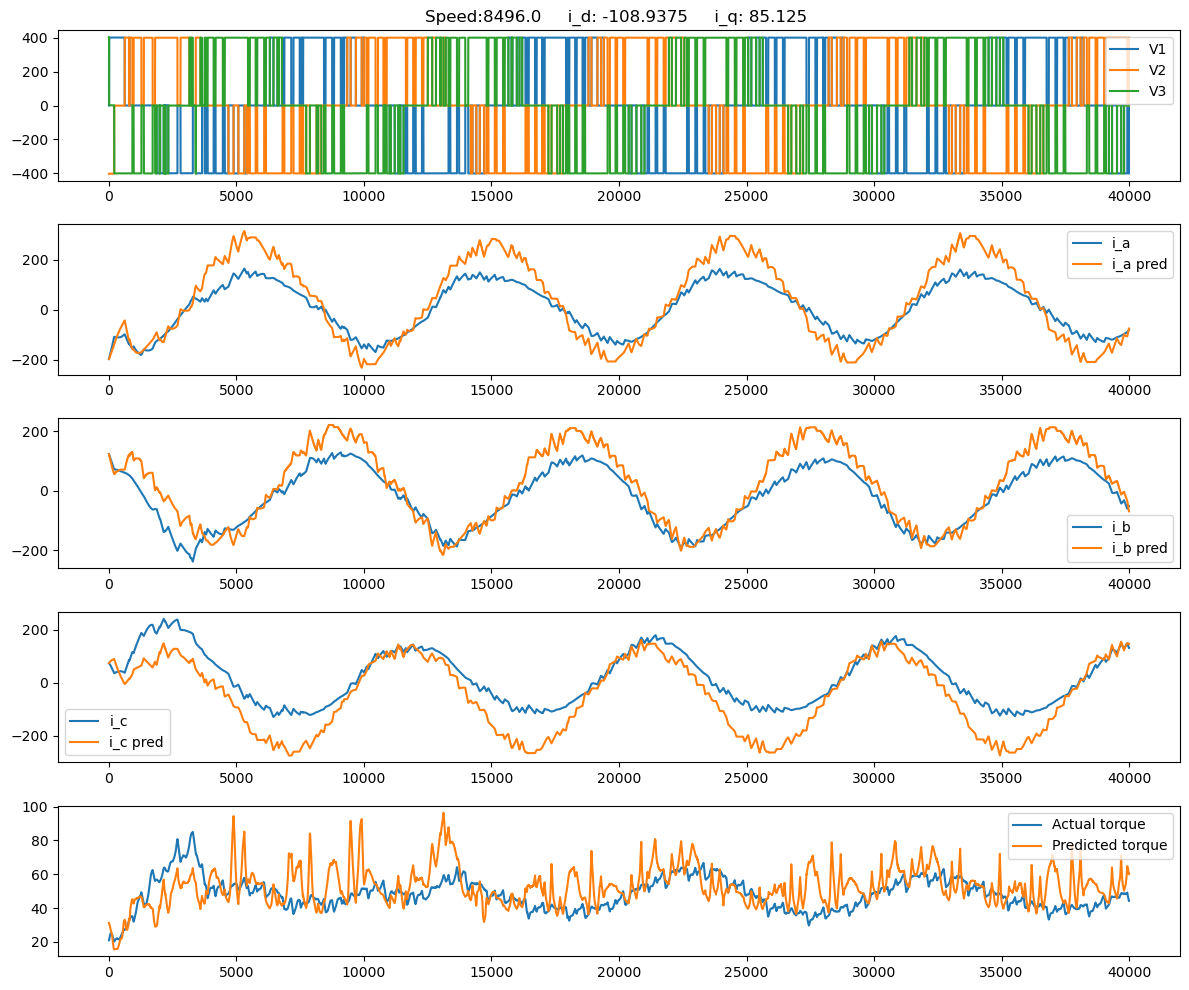

Normalised data - Test error (MAE): 0.1068115234375, Test error (MSE): 0.0174560546875
Denormalised data - Test error (MAE): 42.72008514404297, Test error (MSE): 2793.03662109375

Mean absolute error: 6.27719783782959
Mean squared error: 59.98997497558594
Mean absolute percentage error: 0.19683410227298737
Maximum error: 35.21875


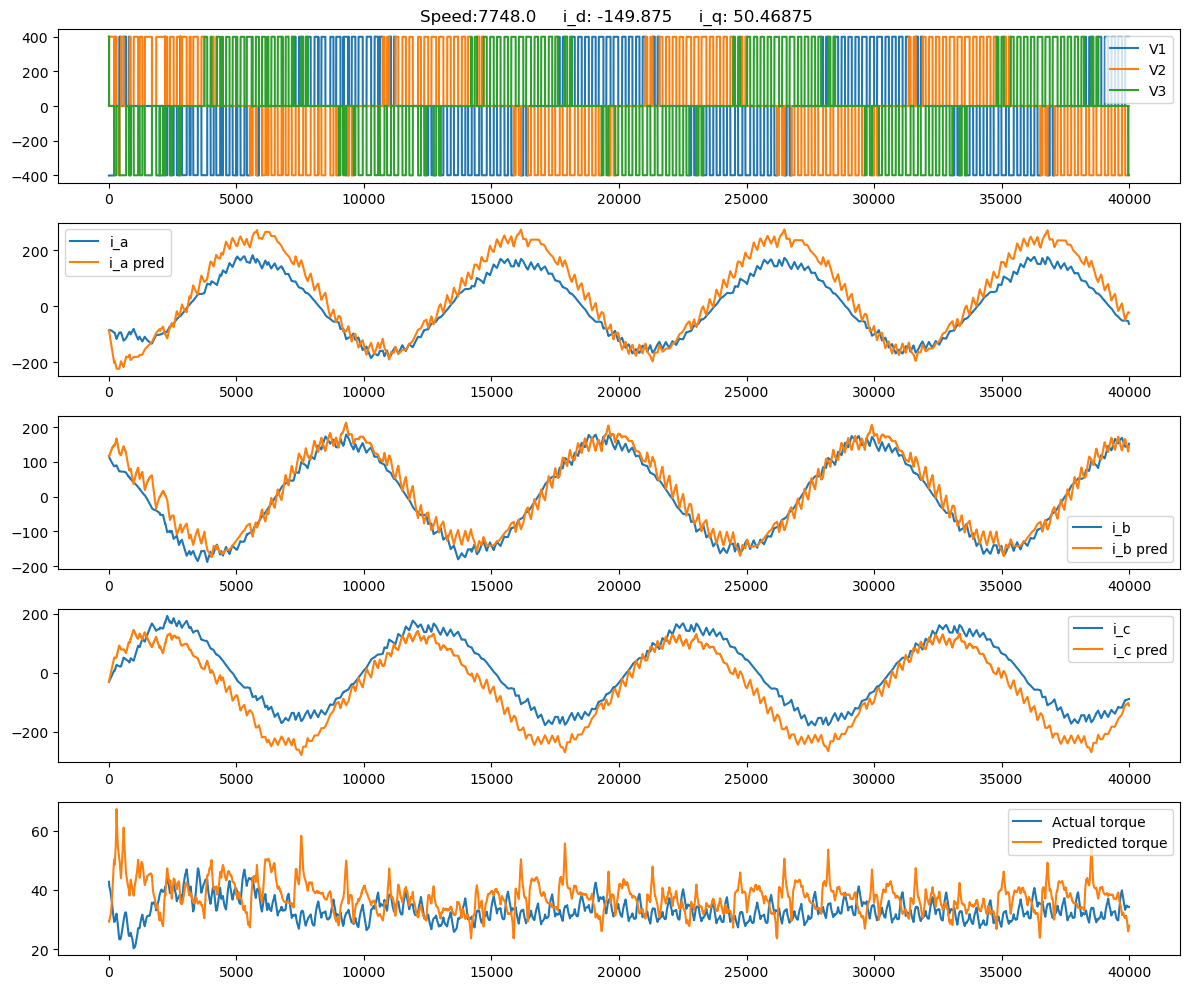

Normalised data - Test error (MAE): 0.149169921875, Test error (MSE): 0.034454345703125
Denormalised data - Test error (MAE): 59.655914306640625, Test error (MSE): 5512.77587890625

Mean absolute error: 14.750433921813965
Mean squared error: 349.38128662109375
Mean absolute percentage error: 0.16148361563682556
Maximum error: 58.96875


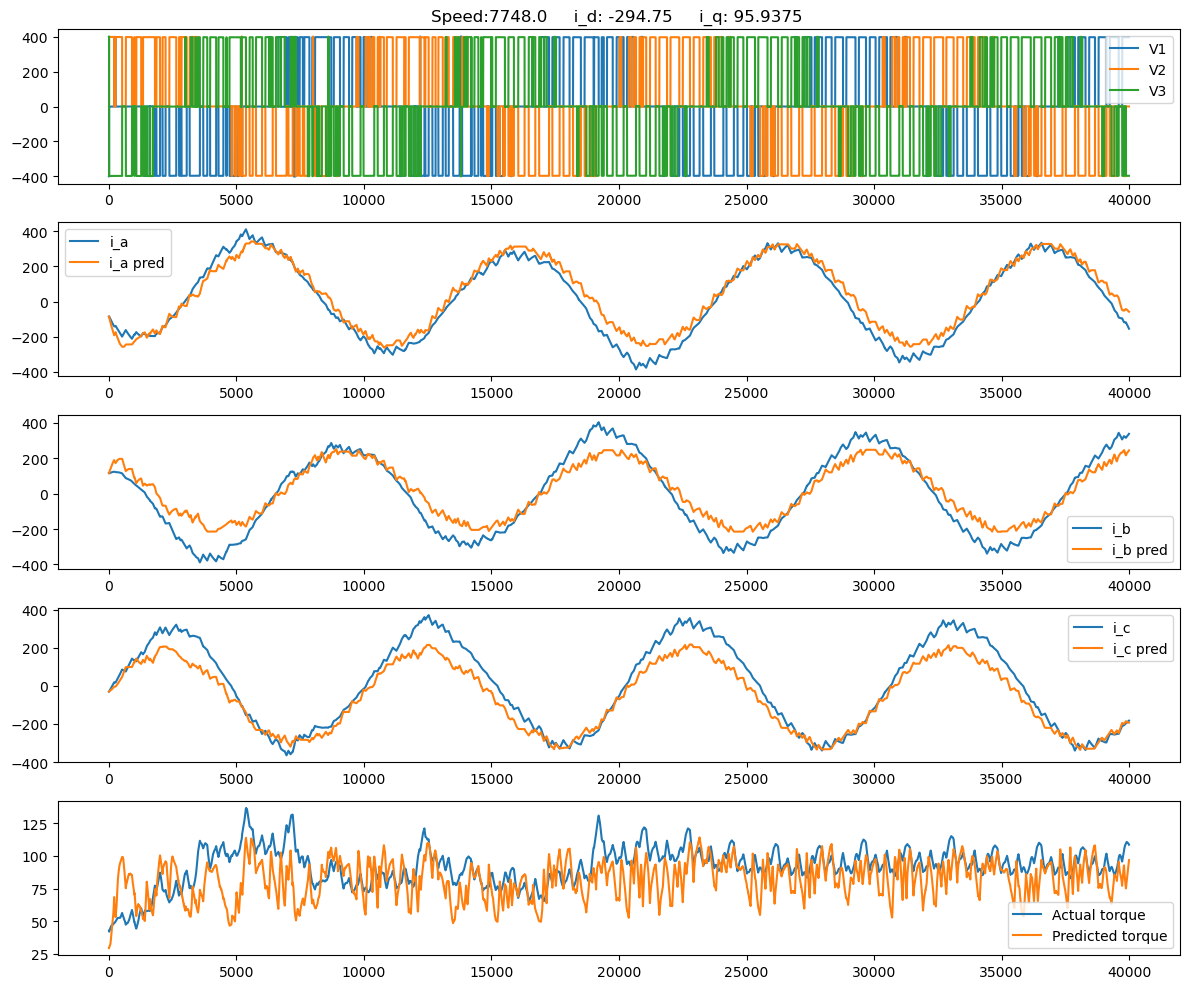

Normalised data - Test error (MAE): 0.1883544921875, Test error (MSE): 0.051513671875
Denormalised data - Test error (MAE): 75.34979248046875, Test error (MSE): 8244.3251953125

Mean absolute error: 11.274589538574219
Mean squared error: 143.52444458007812
Mean absolute percentage error: 0.5528687834739685
Maximum error: 21.890625


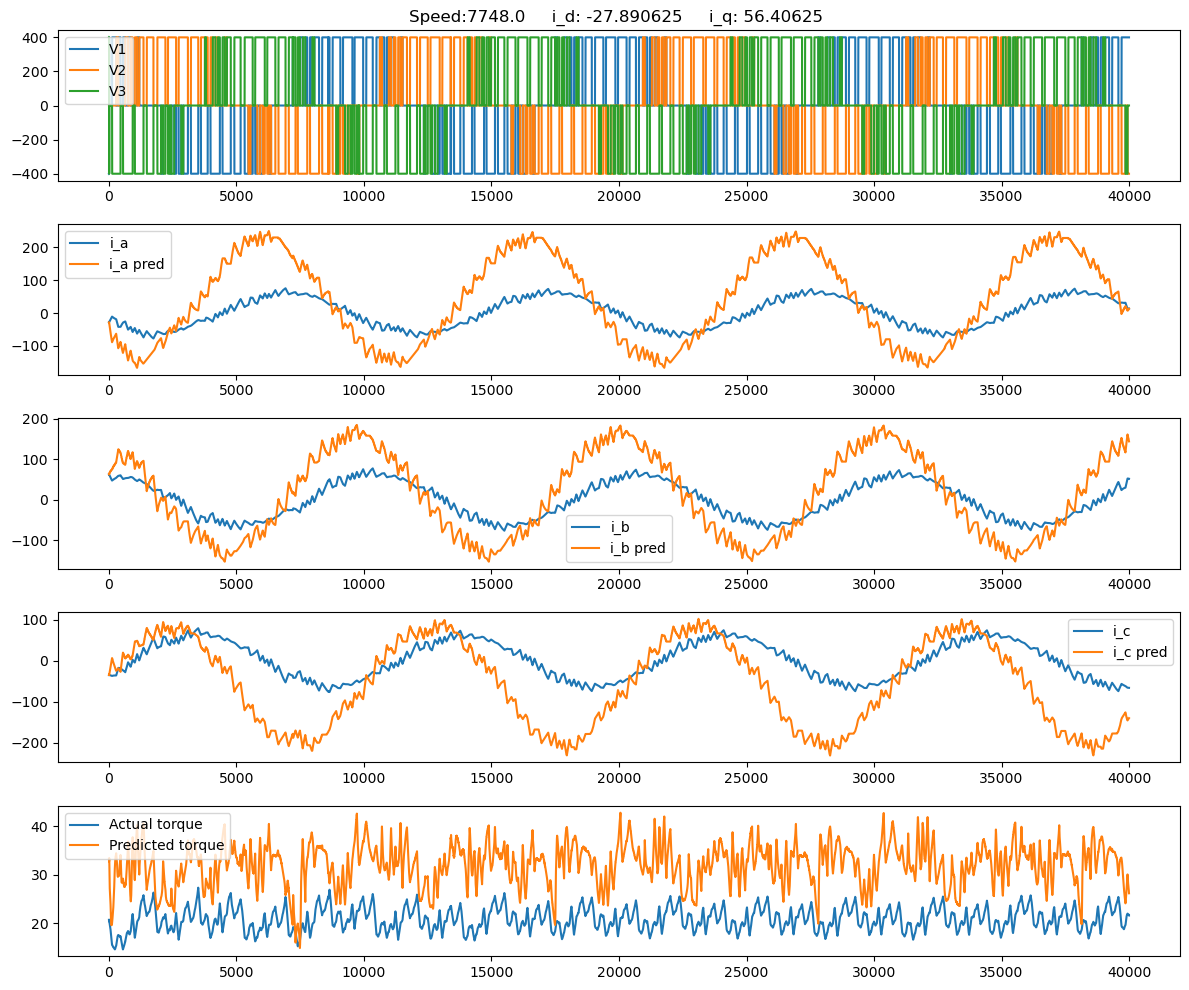

Normalised data - Test error (MAE): 0.122314453125, Test error (MSE): 0.0247802734375
Denormalised data - Test error (MAE): 48.9227409362793, Test error (MSE): 3964.179931640625

Mean absolute error: 5.818381309509277
Mean squared error: 50.36384201049805
Mean absolute percentage error: 0.1167854517698288
Maximum error: 41.28125


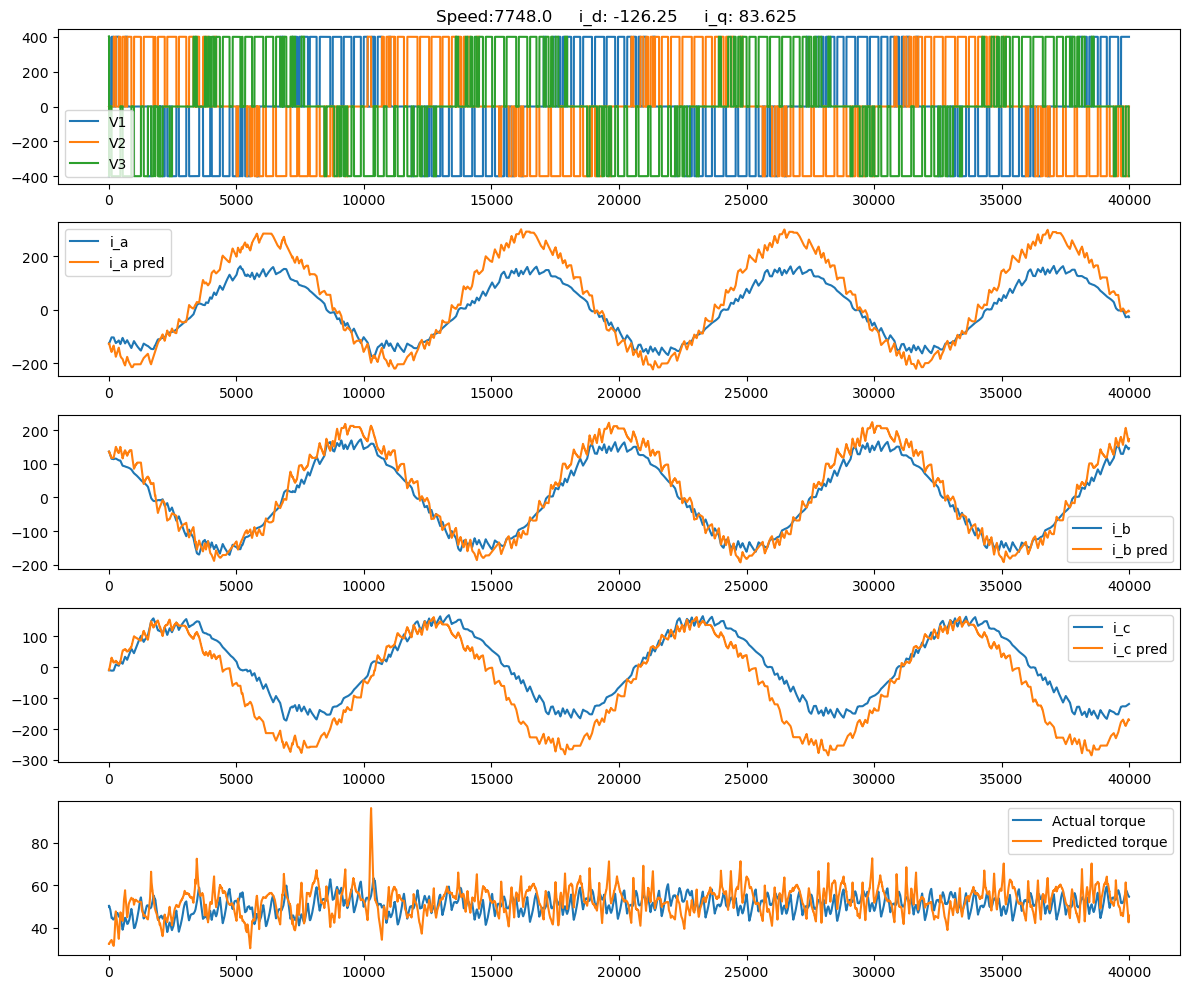

Normalised data - Test error (MAE): 0.1029052734375, Test error (MSE): 0.0164337158203125
Denormalised data - Test error (MAE): 41.167598724365234, Test error (MSE): 2628.250732421875

Mean absolute error: 7.695043563842773
Mean squared error: 94.44627380371094
Mean absolute percentage error: 0.31268590688705444
Maximum error: 30.34375


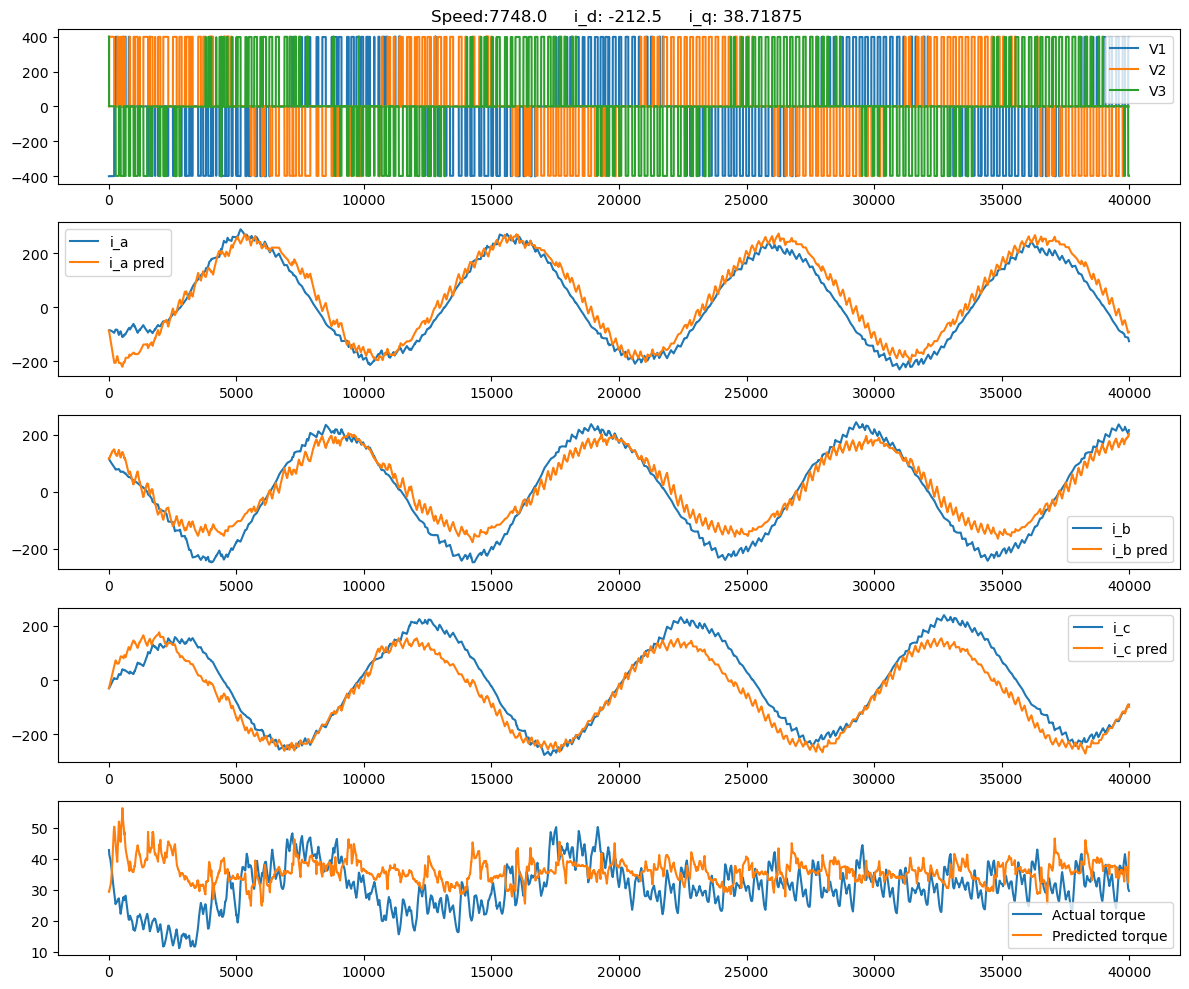

Normalised data - Test error (MAE): 0.11322021484375, Test error (MSE): 0.0178375244140625
Denormalised data - Test error (MAE): 45.282508850097656, Test error (MSE): 2854.4912109375

Mean absolute error: 8.545623779296875
Mean squared error: 114.66809844970703
Mean absolute percentage error: 0.14974285662174225
Maximum error: 35.1875


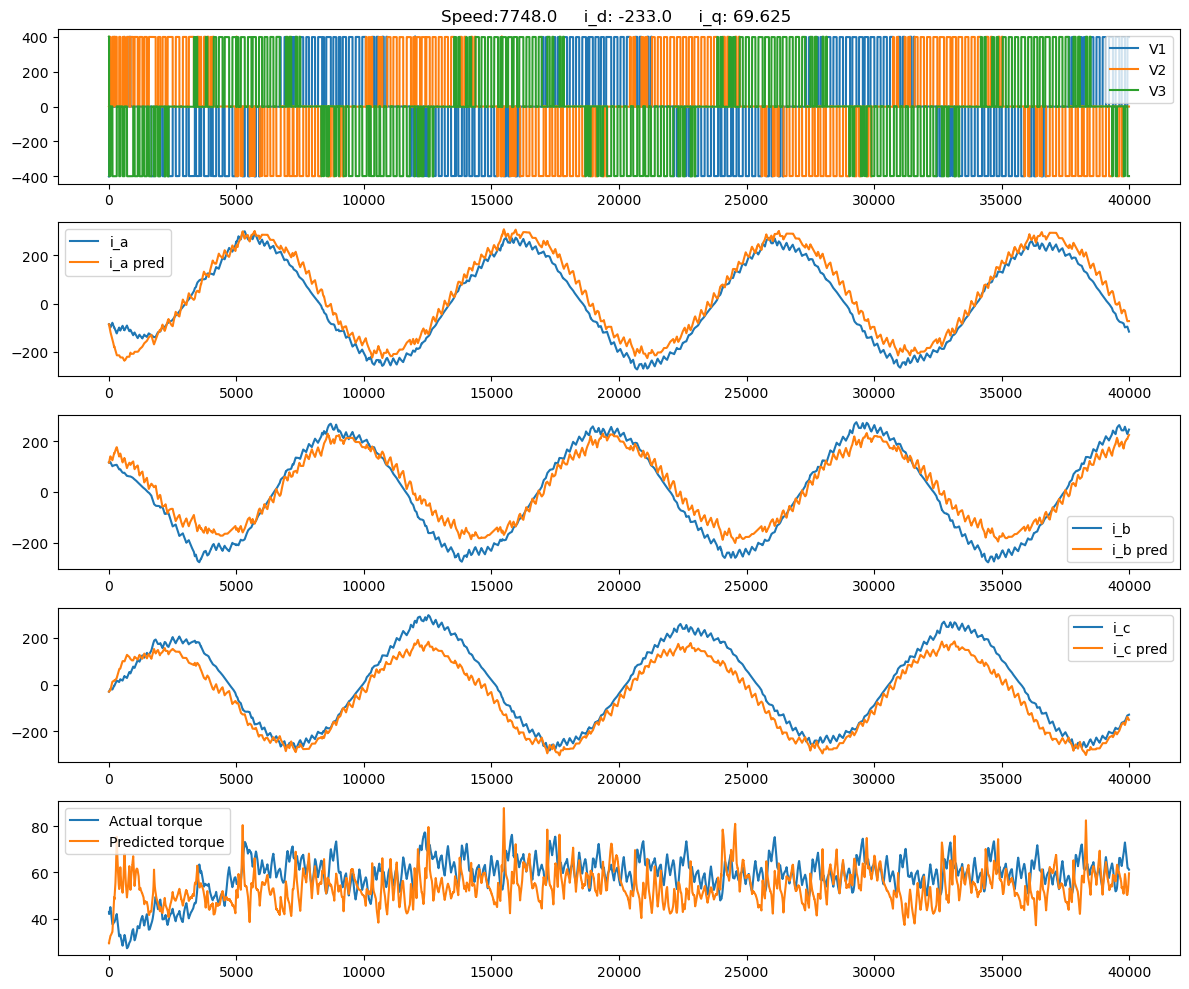

Normalised data - Test error (MAE): 0.11285400390625, Test error (MSE): 0.0178375244140625
Denormalised data - Test error (MAE): 45.1298713684082, Test error (MSE): 2853.376220703125

Mean absolute error: 11.035903930664062
Mean squared error: 205.35948181152344
Mean absolute percentage error: 0.11970417201519012
Maximum error: 55.90625


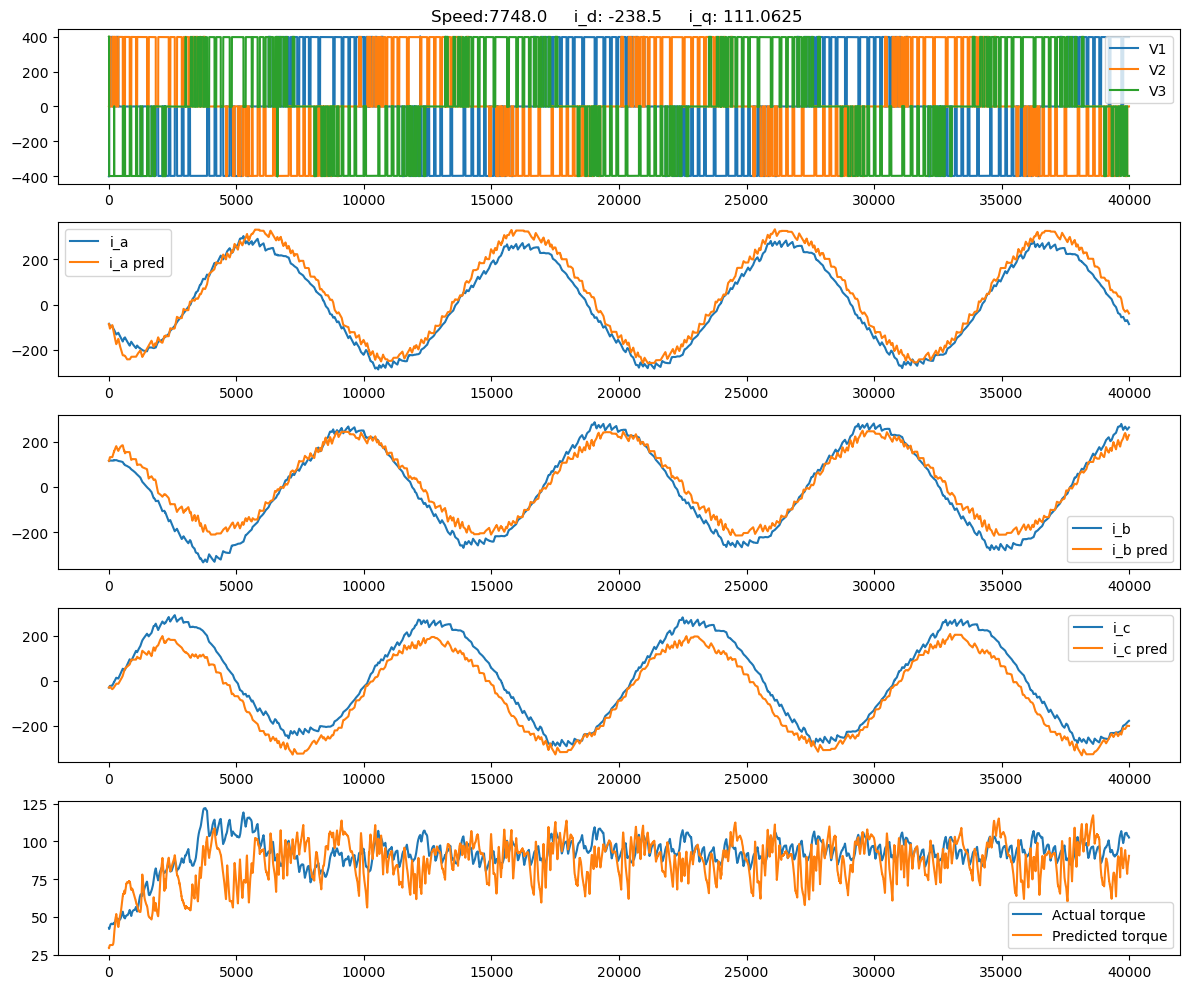

Normalised data - Test error (MAE): 0.113525390625, Test error (MSE): 0.0198822021484375
Denormalised data - Test error (MAE): 45.410099029541016, Test error (MSE): 3180.6650390625

Mean absolute error: 12.98767375946045
Mean squared error: 299.9064025878906
Mean absolute percentage error: 0.11525478214025497
Maximum error: 65.59375


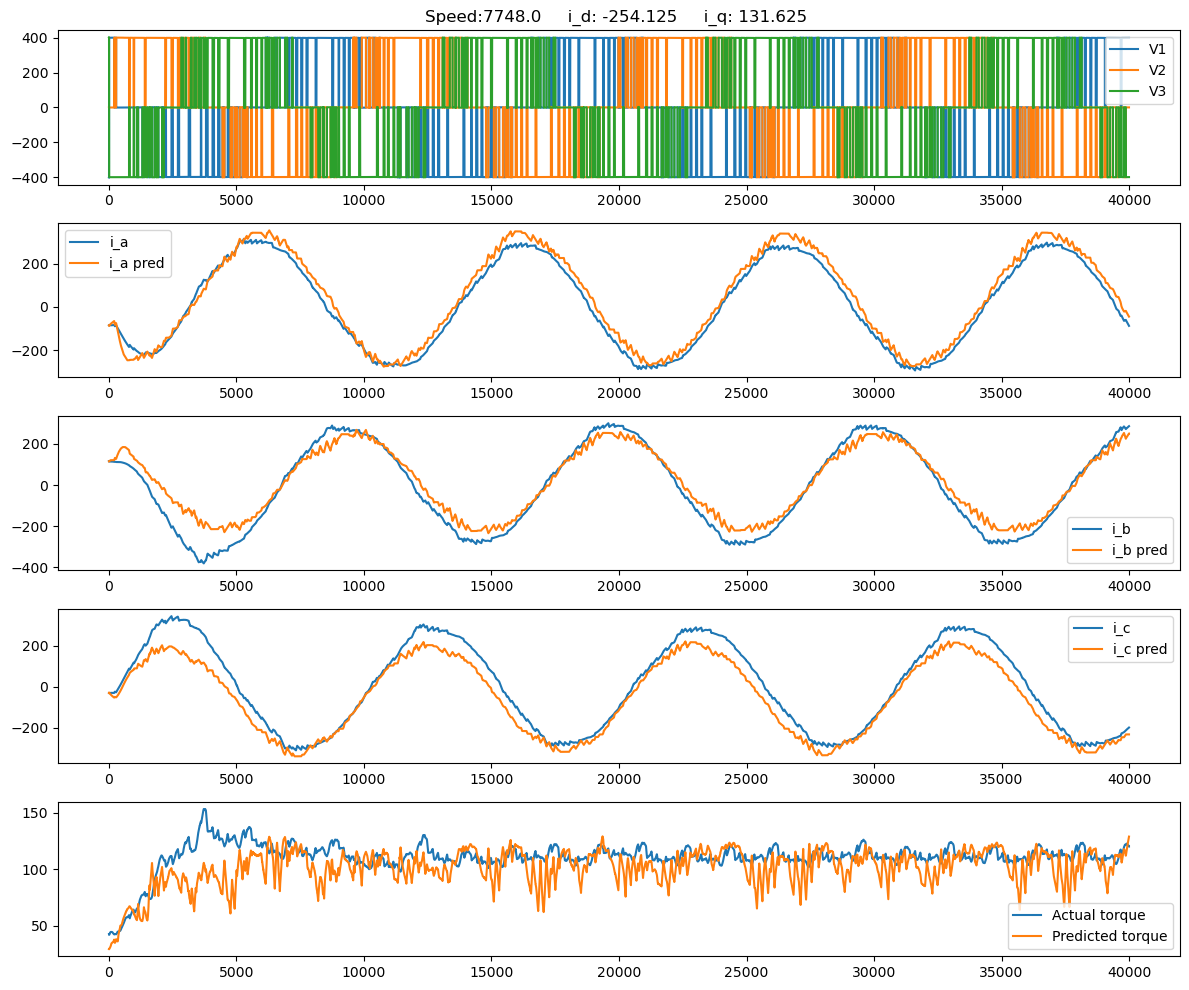

Normalised data - Test error (MAE): 0.1575927734375, Test error (MSE): 0.037078857421875
Denormalised data - Test error (MAE): 63.02194595336914, Test error (MSE): 5933.572265625

Mean absolute error: 7.235339164733887
Mean squared error: 101.07909393310547
Mean absolute percentage error: 0.16558945178985596
Maximum error: 45.015625


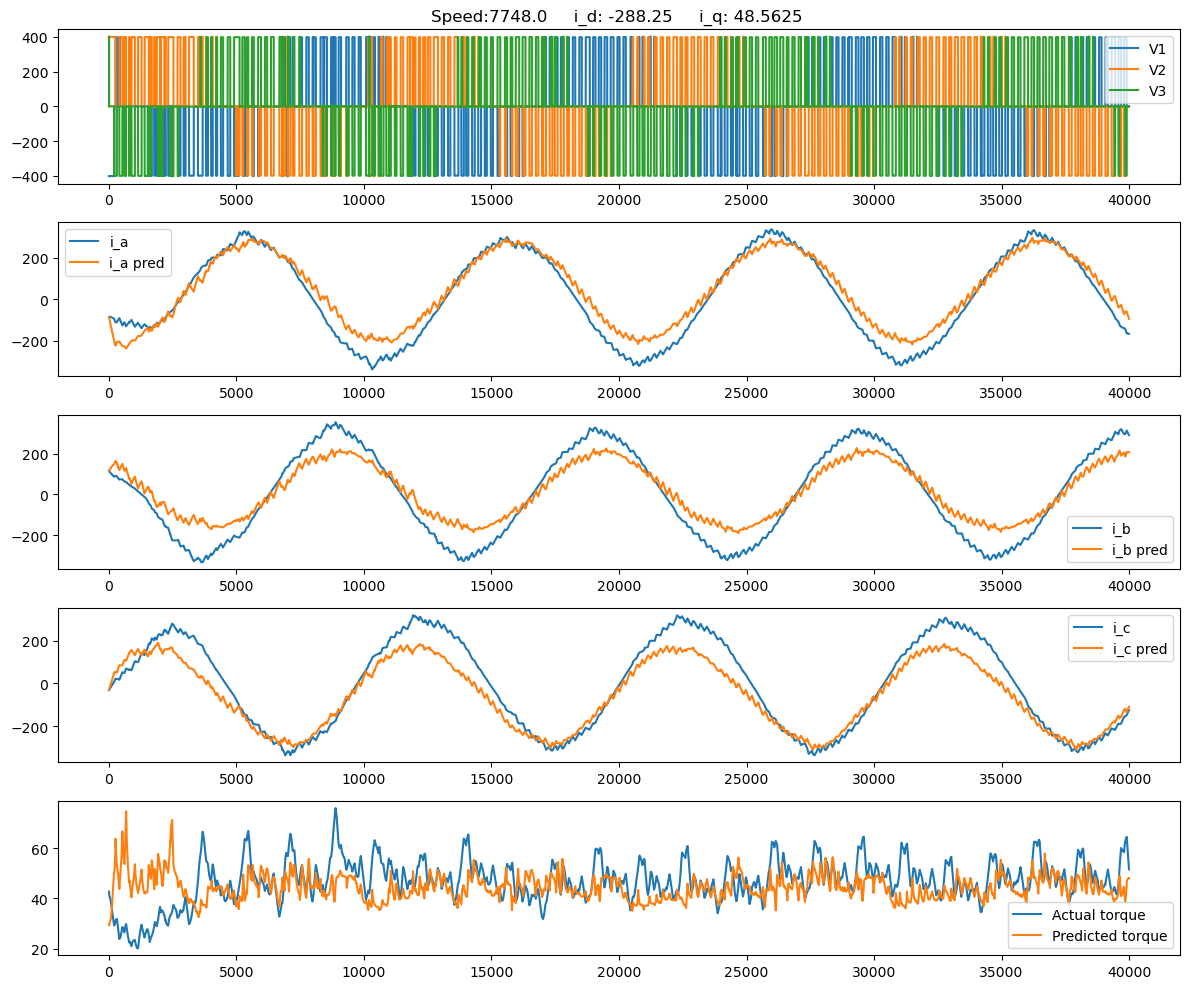

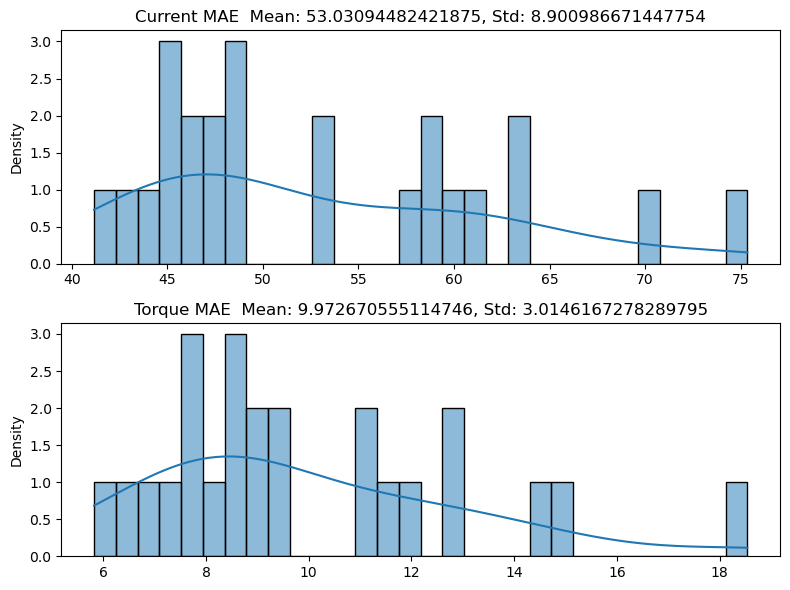

In [ ]:
staticmodel = staticmodel.to(dtype=torch.float16)
current_all_mae = []
torque_all_mae = []
avg_torque = []
i_d = []
i_q = []
speed = []

for i in range(len(test_data)//nsim):
    x_test = X_test_p[i*nsim : (i+1)*nsim]
    x_test_normalised = X_test_normalised[i*nsim : (i+1)*nsim]
    y_test_normalised = Y_test_normalised[i*nsim : (i+1)*nsim]
    y_test = Y_test[i*nsim : (i+1)*nsim]
    
    current_predictions, torque_predictions = inference_sequential_training(dynamicmodel, staticmodel, x_test_normalised, y_test_normalised)
    current_predictions, torque_predictions, current_mae, torque_mae = errormatrix(current_predictions, torque_predictions, y_test_normalised, y_test)
    current_all_mae.append(current_mae)
    torque_all_mae .append(torque_mae)
    avg_torque.append(x_test[0, 8].item())
    i_d.append(x_test[0, 6].item())
    i_q.append(x_test[0, 7].item())
    speed.append(x_test[0, 3].item())
    plot_predictions(x_test, y_test, current_predictions.T, torque_predictions)

current_mean, current_std = np.mean(current_all_mae), np.std(current_all_mae)
torque_mean, torque_std = np.mean(torque_all_mae), np.std(torque_all_mae)

fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.histplot(current_all_mae, kde=True, ax=ax[0], bins=30)
ax[0].set_ylabel("Density")
ax[0].set_title(f"Current MAE  Mean: {current_mean}, Std: {current_std}")

sns.histplot(torque_all_mae, kde=True, ax=ax[1], bins=30)
ax[1].set_ylabel("Density")
ax[1].set_title(f"Torque MAE  Mean: {torque_mean}, Std: {torque_std}")

fig.tight_layout()  
plt.show()

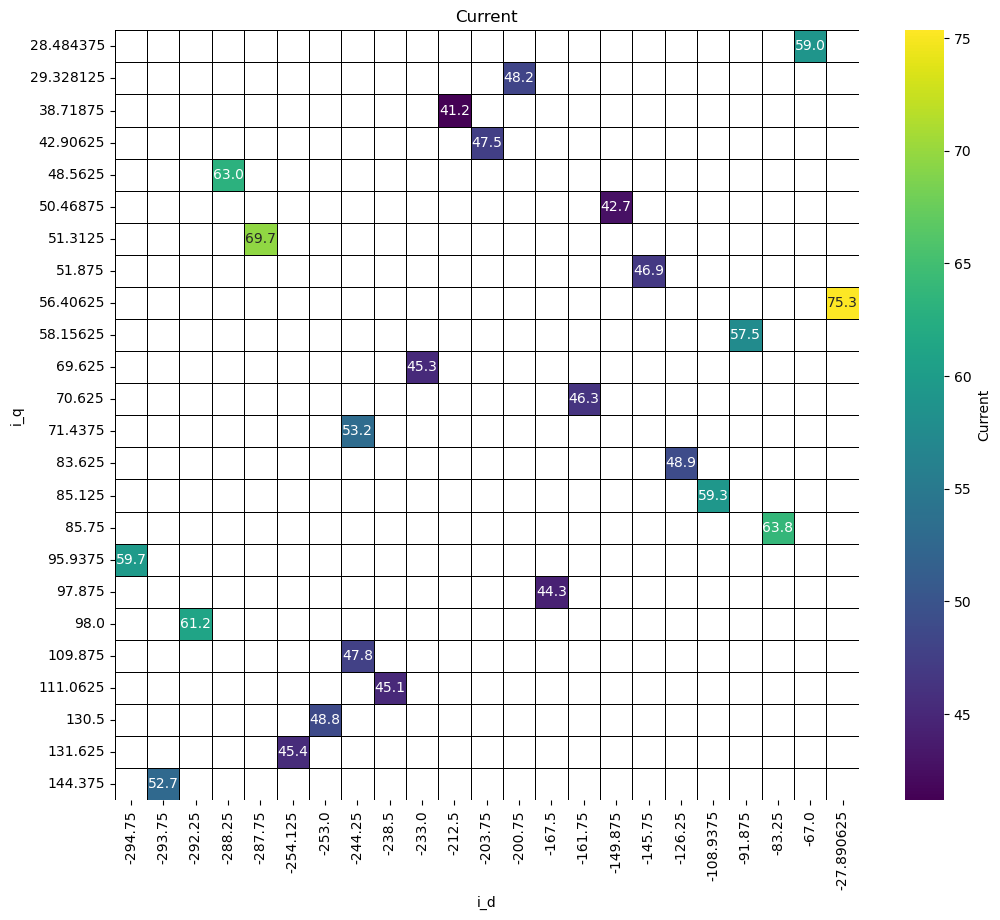

In [ ]:
plot_heatmap_with_values(i_d, 'i_d', i_q, 'i_q', current_all_mae, 'Current', cmap='viridis')